# Technical demand response potential clustering

**Puporse and background**: This notebook serves for clustering the technical demand response potentials 
which were collected in a previous meta-analysis (Kochems 2020). This clustering routine is necessary since depicting all 
different units in the electricity market model would be computationally too expensive.

## Method applied
In the following, a brief description of the method applied is given for the sake of replicability.

### Filtering of demand response categories
The term "demand response categories" is introduced to describe the heterogeneous potential segmentation 
routines used in the publications evaluated within the meta-analysis. These demand response categories include 
processes, applications as well as entrire branches and mixtures of these categories.
* In the first step, data for entire branches is filtered out since in most cases there are to few data points and 
further information on availability is lacking. Thus, only data for processes and applications remain.
* In addition to that, categories covering different branches / appliances are filtered out since these would 
cause redundancies to publications analyzing the appliances in detail.

### Prepare and manipulate data for further usage (clustering / modeling)
In the second step, the data is manipulated for further usage in the clustering process as well as for the ensuing power market model analysis. This in turn consists of a few procedures:
* The data is combined to an overall data set and missing values are interpolated using the median value per sector. The parameters are filtered in order only to include those which are needed in demand response modeling in a power market model.
* A pairwhise correlation analysis using pearson's correlation coefficient is carried out in order to identify which parameters can be expressed through other ones since they show a high correlation. 
* Data is interpolated in order to remove inplausibilities. The data for the status quo is kept. The values for 2030 and 2050 are used to define trends in potential development. A linear interpolation is made in between. As far as the cost values are concerned, the values for the status quo as well as the minimum value are kept. The minimum value is assigned to 2050 and a linear interpolation is made in between.
> _Note: While the interpolation solution is preferable in terms of simplicity, it lacks some consistency: on the one hand in terms of a development of positive and negative potentials in line, on the other hand as for general trends within the sectors (such as declining industry production in the long run). This should be replaced by a more profound approach._

### Clustering of demand response categories
A clustering of demand response categories is carried out in the second step. 
A k-means clustering approach is used (as an alternative, it is possible to choose agglomerative clustering using ward linkage).<br>
Demand response categories are clustered using the (median values of the) following parameters (see also Steurer 2017, p. 83):
* shifting duration
* positive interference duration (shedding duration),
* variable costs,
* fixed costs and
* specific investments.

Some further aspects are worth mentioning:
* Negative interference duration is not taken into account because some processes are only eligible for load shedding and hence don't have a negative interference duration. In addition to that, a strong correlation between positive and negative interference duration has been detected.
* The clustering does not need to take into account the lower, middle and upper value for each parameter. A strong correlation between the values was determined which is why only the median values are used for the clustering. 
* Furthermore, the clustering is only carried out for the status quo and does not take development projections into account.
* The distinction between different sectors is kept. Some heating and cooling applications for tcs and households are combined since they comprise basically the same technology and creating identical clusters would not make much sense.
* For the aggregation of demand response parameters after clustering, a weighting by the available shifting resp. shedding capacity is carried out.

### Determination of availability
Since demand response potentials are time-dependent, availability has to be taken into account.<br>
For the analysis, the individual availability time series in hourly resolution of the original 
demand response categories are put together by calculating capacity weighted averages for the identified 
demand response clusters.

The availability time series are put together based on literature assumptions:
* The largest amount of the availability time series for individual demand response categories were created within three bachelor theses based on literature assumptions. They were put together in a separate notebook. The data output of this notebook in turn is read in here to form availability time series of demand response clusters.
* Some processes haven't been analyzed in the bachelor theses resp. the literature. For these, either existing availability time series of very similar demand response categories are assigned or own assumptions are made.
> _Note: These own assumptions for now are ("best guess") dummy values and should be replaced by more profound ones._
***

__*Important remaining TODOs:*__
* __*Revise parameters and potential development by including trend extrapolation / assumptions*__
* __*Revise proxies for availability time series*__
* __*Include the distinction between shifting and shedding &rarr; should be a criterion for separate cluster assignment*__

# Package imports
* Standard imports: scikit-learn (sklearn) is used for the clustering since it has built-in clustering routines, such as K-means
* User-defined functions:
    * *create_parameter_combinations*: Combines parameter names with measures of central tendency
    * *group_potential*: Does a grouping of the clusters determined using given aggregation functions per parameter
    * *wtrie_multiple_sheets*: Used to write multiple DataFrames as sheets at once into an Excel workbook
    * *map_column_names*: Maps column names of availability time series to the potential data column names.
    * *determine_missing_columns*: Lists the columns for which availability time series information is lacking and assumptions are needed.
    * *get_top_abs_correlations*: Determines the strongest correlation within a given correlation matrix.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import linregress
from IPython.core.display import display

from potential_clustering_funcs_V05 import (create_parameter_combinations, group_potential, write_multiple_sheets,
    map_column_names, determine_missing_cols, assign_availability_remaining, get_top_abs_correlations)

In [2]:
%matplotlib inline

# Parameter settings
Set path folder and filenames for reading in data.

Further parameters for controlling the workflow:
* *skip_dev*: If True, skip cells that are currently under development to keep overall functionality of notebook
* *write_outputs*: If True, outputs, i.e. demand response parameterizations resulting from the meta-analysis will be written into Excel workbooks
* *join_duplicates*: If True, demand response categories occuring in both, household and tcs sector will be combined together.
* *write_categories*: If True, the remaining categories will be written to Excel in order to match them with the
availability data.
* *adjust_potentials*: If True, availability time series information will be used to adjust the potential information. (I. e. if at max. 0.8 is reached, max potential will be set to 0.8 * max_potential)

Parameters for controlling the clustering routines:
* *cols*: Determine, which columns of the stats DataFrame shall be used for demand response parameterization
    * Usually lower and upper quartile as well as median are used.
> Note: This eliminates extreme values which are taken into account when min and max are used instead.<br>
The upper quartile of overall potential will be interpreted as maximum available potential. A possible alternative would be to use min and max values to depict extremes. &rarr; Advantage: would be more compelling. Drawback: Data lack for potential max.
* *cluster_parameters*: Determine, which demand response parameters to use for the clustering process. 
By default, these are the shifting duration, positive interference duration, variable costs as well as fixed costs.
* *cluster_algo*: The clustering algorithmn to be used ("KMeans" or "ward")
* *share_clusters*: Decide, how strong the original data will be reduced by giving a percentage of the original length. 
The cluster number is determined by the next higher integer. (Only applicable for k-means)
* *distance_threshold*: Decide, what distance threshold shall be set for the hierarchical clustering using ward 
linkage, i.e., when the algorithm should terminate.
* *print_clusters*: If True, prints out the clusters created (DataFrames)
* *use_ava_ts_for_profiles*: If True, availability time series in positive direction will be directly used to derive load profiles for the demand response categories resp. clusters, else profiles from the demand regio disaggregator will be applied

In [3]:
# Set path folder(s) and filename(s) for reading in / writing data
path_folder_in = "./"
path_folder_stats = "./out/stats/"
path_folder_availability = "./out/availability/"
path_folder_parameterization = "./out/parameterization/"
version_number = "V86"
filename_in = "2019-02-16_Potenziale_Lastmanagement_" + version_number + ".xlsx"
filename_availability_in = "availability_timeseries.xlsx"
filename_out = "parameterization"
filename_corr_out = "correlation"
filename_availability_out = "availability_timeseries_clusters.csv"
filename_load_profiles_out = "load_profile_timeseries_clusters"

# Set further parameters for controlling the workflow
skip_dev = True
write_outputs = True
join_duplicates = True
write_categories = True
adjust_potentials = True

# Determine clustering approach
cols = ["25%", "50%", "75%"]
cluster_parameters = ["shifting_duration", "interference_duration_pos", 
                      "variable_costs", "fixed_costs", "specific_investments"]
# Correlation analysis: optionally add potential_pos_overall (for all potential metrics)

cluster_algo = "KMeans"
share_clusters = 0.1
distance_threshold = 1000
print_clusters = True
use_ava_ts_for_profiles = True

# Read in and filter data
* Read in the categories data and filter out branches as well as power-to-X-technologies which won't be considered anymore.
* Read in the stats information on the demand response parameters from the previous meta-analysis.

> _NOTE: Data that is read in here could also be obtained directly from the DataFrames of the potential evaluation notebook. A separate notebook is used here only for the sake of shortness and readability._

## Read in and filter demand response categories
Read in demand response categories and filter out entire branches as well as categories conflicting with others or outside of scope.
Show the original number of categories and print the remaining number after filtering (without duplicates since categories may be used within different sectors).

In [4]:
# Read in demand response categories from worksheet and filter out branches resp. power-to-X-technologies.
# Drop categories summarizing over several technologies / applications as well as categories not eligible or not whithin scope.
cats_to_drop = ["QST gesamt", "Raumwärme", 
                "Hybrid-Wärmeerzeugungssysteme (Widerstandserhitzer / Wärmepumpe + Erdgas-Brennwertkessel)",
                "elektrische Direktheizungen"]

categories = pd.read_excel(path_folder_in+filename_in, sheet_name="Kategorien", index_col=0)
print("Number of original categories:\t{}".format(categories.shape[0]))
categories = categories[categories["Nutzung Prozesskategorie 1"] == 1 & 
                        ~categories["Einstufung"].isin(["Branche", "Power-to-X"])]
categories = categories.drop_duplicates(subset="Prozesskategorie 1")
categories = categories.set_index(["Prozesskategorie 1"], drop=True).drop(cats_to_drop)
print("Number of remaining categories:\t{}".format(categories.shape[0]))

# Show the remaining demand response categories which are evaluated
list(categories.index.values)

Number of original categories:	98
Number of remaining categories:	38


['Chlor-Alkali-Elektrolyse',
 'Luftzerlegung',
 'Primäraluminiumelektrolyse',
 'Kupfer- und Zinkherstellung (Elektrolyse)',
 'Holz- und Zellstoffherstellung',
 'Altpapierrecycling (Pulper)',
 'Papiermaschinen',
 'Papierveredelung (Streichmaschinen und Kalander)',
 'Elektrostahlherstellung (Lichtbogenofen)',
 'Zementherstellung',
 'Kühlung (Lebensmittelindustrie)',
 'Belüftung',
 'Kühlhäuser',
 'Prozesskälte',
 'Klimakälte',
 'Warmwasserbereitstellung',
 'Nachtspeicherheizungen',
 'Notstromaggregate, Back-Up-Server und Mobilfunkstationen',
 'Waschmaschinen',
 'Wäschetrockner',
 'Geschirrspüler',
 'Kühlschränke',
 'Gefrierschränke und -truhen',
 'Wärmepumpen',
 'Heizungsumwälzpumpen',
 'Prozesswärme',
 'Druckluftanwendungen',
 'Abwasserbehandlung',
 'Kühl- und Gefrierkombinationen',
 'Calciumcarbid-Herstellung (Lichtbogenofen)',
 'Pumpenanwendungen in der Wasserversorgung',
 'Prozesskälte Handel',
 'Beleuchtung',
 'Pumpenanwendungen',
 'Gießereien (Induktionsofen)',
 'Zerkleinerer',
 'El

## Read in demand response parameters data
* Assign each demand response parameter an aggregation function to be used after clustering (sum or mean).
* Determine for which parameters to swap the order of preference.
> _Note: This is necessary, because in some cases minimum values are needed for an optimistic 
demand response projection and maximum for a pessimistic one, e.g. for minimum load factor. <br>
Hence, for these parameters, min is exchanged for max etc._
* Read in the data and store it in a dictionary indexed by demand response parameter. Hereby, a separation is necessary:
    * For the clustering process, certain appliances for the household and tcs sector should be combined, e.g. heat pumps. A new sector "tcs+hoho" is introduced for this purpose and the respective values are combined.
    * For calculating availabilities, a (re-)separation is necessary. This is because availability time series of the appliances may (slightly) differ among the sectors. &rarr; Herefore, a second dict is introduced.

In [5]:
# Assgin each parameter the aggregation function to be used.
# Furthermore, decide whether or not to swap the order of entries.
parameters_groups_dict = {"activation_duration": ("mean", "swap"), 
                          "ave_load": ("mean", "swap"), 
                          "fixed_costs":("mean", "swap"), 
                          "installed_cap": ("sum", "no_swap"),
                          "interference_duration_neg": ("mean", "no_swap"), 
                          "interference_duration_pos": ("mean", "no_swap"),
                          "max_load": ("mean", "no_swap"), 
                          "maximum_activations_year": ("mean", "no_swap"), 
                          "min_load": ("mean", "swap"), 
                          "potential_neg_ave": ("sum", "swap"), 
                          "potential_neg_min": ("sum", "swap"), 
                          "potential_neg_max": ("sum", "swap"), 
                          "potential_neg_overall": ("sum", "swap"),
                          "potential_pos_ave": ("sum", "no_swap"), 
                          "potential_pos_min": ("sum", "no_swap"), 
                          "potential_pos_max": ("sum", "no_swap"), 
                          "potential_pos_overall": ("sum", "no_swap"),
                          "regeneration_duration": ("mean", "swap"), 
                          "shiftable_share": ("mean", "no_swap"), 
                          "shifting_duration": ("mean", "no_swap"),
                          "specific_investments": ("mean", "swap"), 
                          "variable_costs": ("mean", "swap")}

sectors = ["ind", "tcs", "hoho"]

years = ["SQ", "2020", "2025", "2030", "2035", "2040", "2045", "2050"]

to_join = ["Nachtspeicherheizungen", "Warmwasserbereitstellung", "Wärmepumpen", "Klimakälte"]
to_drop = {"Prozesskälte": "hoho"}

> _NOTE: While the fundamental routine here is quite okay and fast enough, there is room for improvement in the aggregation routine for the duplicates DataFrame, i.e. the DataFrame containing data for tcs+hoho which is then aggregated. Fo a compelling approach, a capacity weighted average should be calaculated using overall positive potential as capacity information. In order to do so, capacity information has to be added to the individual data sets._

In [6]:
# parameters_dict holds the data for all demand response parameters, sectors and years.
# It is indexed by the parameters.
# parameters_dict_nojoin is basically the same, but without filtering out 
# resp. joining duplicate values for different sectors.
parameters_dict = {}
parameters_dict_nojoin = {}

# Count the number of params for which no data is available
count_ignored = 0

for parameter in parameters_groups_dict.keys():
    parameters_dict[parameter] = pd.DataFrame(columns=["sector", "count", "mean", "std", 
                                                       "min", "25%", "50%", "75%", "max", "year_key"])
    for year in years:
        for sector in sectors:
            try:
                new_df = pd.read_excel(path_folder_stats+parameter+"_"+sector+"_stats.xlsx", 
                                       sheet_name=year, 
                                       index_col=0).T
                new_df["sector"] = sector
                new_df["year_key"] = year
                parameters_dict[parameter] = pd.concat([parameters_dict[parameter], new_df], sort="False")
            except:
                count_ignored += 1
                continue
        
        # Filter out the categories to be used and temporarily change index for further filtering
        parameters_dict[parameter] = parameters_dict[parameter][parameters_dict[parameter].index.isin(categories.index)]
        parameters_dict[parameter] = parameters_dict[parameter].set_index([parameters_dict[parameter].index, "sector"], 
                                                                          drop=False)
        # Drop certain load management categories for certain sectors only
        for k, v in to_drop.items():
            if ((k, v)) in parameters_dict[parameter].index:
                parameters_dict[parameter] = parameters_dict[parameter].drop(((k, v)))
        parameters_dict[parameter] = parameters_dict[parameter].set_index(
            parameters_dict[parameter].index.get_level_values(0))
        parameters_dict[parameter].index.name = "Prozess"
        
        parameters_dict_nojoin[parameter] = parameters_dict[parameter]

    # Combine demand response categories for tcs and and sector
    if join_duplicates:
        # Remove duplicate values in index for tcs and households sector
        parameters_dict[parameter] = parameters_dict[parameter].set_index([parameters_dict[parameter].index, "year_key"])
        duplicates = (parameters_dict[parameter].index.duplicated(keep=False) 
                      & parameters_dict[parameter]["sector"].isin(["hoho", "tcs"]))

        # Get duplicates within duplicates (i.e. filter out the values where 
        # the same demand response categories occur in tcs and industry sector)
        duplicates_df = parameters_dict[parameter][duplicates]
        duplicates_df = duplicates_df[duplicates_df.index.duplicated(keep=False)]
        
        # Filter out the remaining duplicate values from original DataFrame
        keys = list(duplicates_df.columns.values)
        i1 = parameters_dict[parameter].set_index(keys).index
        i2 = duplicates_df.set_index(keys).index
        no_duplicates_df = parameters_dict[parameter][~i1.isin(i2)]
        
        # Assign certain demand response categories to a mix of tcs+hoho sector
        for el in to_join:
            if el in no_duplicates_df.index:
                no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x: 
                                                                                   x if x == "ind" else "tcs+hoho")
                no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
                no_duplicates_df = no_duplicates_df.drop(["help_sector"], axis=1)
                
        # drop index for grouping
        duplicates_df = duplicates_df.reset_index(drop=False)
        no_duplicates_df = no_duplicates_df.reset_index(drop=False)

        if not duplicates_df.empty:

            # Aggregate values for the remaining duplicates dependent on the kind of parameter
            if parameters_groups_dict[parameter][0] == "mean":
                duplicates_df = group_potential(duplicates_df, grouping_cols=["Prozess", "year_key"], 
                                                mean_cols=["25%", "50%", "75%", "mean", "std"], sum_cols=["count"],
                                                min_cols=["min"], max_cols=["max"], add_cluster=False, 
                                                weighted_ave=False)
            else:
                duplicates_df = group_potential(duplicates_df, grouping_cols=["Prozess", "year_key"], 
                                                sum_cols=["min", "max", "25%", "50%", "75%", "mean", "std", "count"],
                                                add_cluster=False, weighted_ave=False)

            # Add sector information again and concat original DataFrame and the aggregated remaining duplicates again
            duplicates_df["sector"] = "tcs+hoho"
        
        parameters_dict[parameter] = pd.concat([no_duplicates_df, duplicates_df], 
                                               sort=False).set_index("Prozess")

    # Change the order of preference for certain parameters
    if parameters_groups_dict[parameter][1] == "swap":
        try:
            parameters_dict[parameter][["min_copy","25%_copy", 
                                        "75%_copy", "max_copy"]] = parameters_dict[parameter][["min", "25%", 
                                                                                               "75%", "max"]]
            parameters_dict[parameter][["min", "25%", 
                                        "75%", "max"]] = parameters_dict[parameter][["max_copy", "75%_copy", 
                                                                                     "25%_copy", "min_copy"]]
            parameters_dict[parameter] = parameters_dict[parameter].drop(["min_copy","25%_copy", 
                                                                          "75%_copy", "max_copy"], axis=1)

            parameters_dict_nojoin[parameter][["min_copy","25%_copy", 
                                               "75%_copy", "max_copy"]] = parameters_dict_nojoin[parameter][["min", "25%", 
                                                                                                             "75%", "max"]]
            parameters_dict_nojoin[parameter][["min", "25%", 
                                               "75%", "max"]] = parameters_dict_nojoin[parameter][["max_copy", "75%_copy", 
                                                                                                   "25%_copy", "min_copy"]]
            parameters_dict_nojoin[parameter] = parameters_dict_nojoin[parameter].drop(["min_copy","25%_copy", 
                                                                                        "75%_copy", "max_copy"], axis=1)
        except:
            continue

if join_duplicates:
    sectors.append("tcs+hoho")

print("Overall number of params (sectors, years, params): "+str(len(parameters_groups_dict) * (len(sectors) -1) * len(years)))
print("Number of params not eligible for evaluation: "+str(count_ignored))

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\ipykernel\zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
<ipython-input-6-05b359554197>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_duplicates_df["help_sector"] = no_duplicates_df["sector"].apply(lambda x:
<ipython-input-6-05b359554197>:64: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self

Overall number of params (sectors, years, params): 528
Number of params not eligible for evaluation: 74


In [7]:
# Show an excerpt (example: overall positive shifting potential)
parameters_dict["potential_pos_overall"][parameters_dict["potential_pos_overall"]["year_key"] == "2050"].head()

,year_key,25%,50%,75%,count,max,mean,min,sector,std
Prozess,,,,,,,,,,
Primäraluminiumelektrolyse,2050,150.645161,200.000000,606.550000,7.0,658.000000,352.645622,96.129032,ind,256.157785
Chlor-Alkali-Elektrolyse,2050,323.599235,393.000000,572.926998,7.0,884.509523,464.365999,180.000000,ind,236.320254
Holz- und Zellstoffherstellung,2050,123.020000,196.593939,223.475000,7.0,324.870000,180.402392,48.362807,ind,90.251460
Altpapierrecycling (Pulper),2050,755.301004,898.173541,1004.132848,4.0,1100.531393,861.260311,548.162770,ind,237.280836
Papiermaschinen,2050,1028.952500,1589.625000,2064.157500,4.0,2538.690000,1503.485000,296.000000,ind,956.498926


# Prepare and manipulate data for further usage

## Put together parameter info and fill missing values
* Put together all parameter information for a given sector in order to prepare for clustering
* Deal with missing values:
    * Calculate averages per sector and assing these.
    * If information is still lacking for the status quo, fill remaining values with 0s for the status quo year. Since this is only applicable to the parameters activation duration, regeneration duration and variable costs, this causes no problems. Variable costs values of 0 are replaced later.
* Round data to two decimal places.

> _Note: In general, there are several options possible for dealing with missing data:_
> * Drop missing values &rarr; Is not recommended and would eliminate all data
> * Fill NaN values (and round data)
>    * Use 0 values to fill NaN &rarr; changes the cluster decision itself 
>    * Use averages per sector &rarr; changes the cluster decision itself (approach is used at the moment)
>    * Use imputations: https://scikit-learn.org/stable/modules/impute.html &rarr; state of the art but easy to make mistakes
>    * Alternative to filling missing values: Partial cluster analysis (not supported by scikit-learn).
>
> See for options to deal with missing data: https://www.displayr.com/5-ways-deal-missing-data-cluster-analysis/

In [8]:
# Create a separate DataFrame for every year key and store it in potential dict (indexed by year keys)
# The clustering is carried out based on status quo data
potential_dict = {}
potential_dict_nojoin = {}

for year in years:
    # Create a DataFrame to store the information on all demand response parameters
    df_potential = pd.DataFrame(columns=["Prozess", "sector", "year_key"]).set_index("Prozess")
    df_potential_nojoin = pd.DataFrame(columns=["Prozess", "sector", "year_key"]).set_index("Prozess")

    cols_new = cols.copy()
    cols_new.extend(["sector", "year_key"])

    # Put together the information for all demand response parameters
    for k, v in parameters_dict.items():
        try:
            to_merge = v[cols_new][v["year_key"] == year]
            if not to_merge.empty:
                df_potential = pd.merge(df_potential, to_merge, on=["Prozess", "sector", "year_key"], 
                                        suffixes=["","_"+k], how="outer")
        except:
            continue
            
    # Put together the information for all demand response parameters (not joined version)
    for k, v in parameters_dict_nojoin.items():
        try:
            to_merge = v[cols_new][v["year_key"] == year]
            if not to_merge.empty:
                df_potential_nojoin = pd.merge(df_potential_nojoin, to_merge, on=["Prozess", "sector", "year_key"], 
                                               suffixes=["","_"+k], how="outer")
        except:
            continue

    # Rename data for the first parameter (activation duration) which is lost in the merging process
    # Set process and sector as index to obtain unique values
    df_potential = df_potential.rename(columns={col: col+"_"+list(parameters_groups_dict.keys())[0] 
                                                for col in cols})
    
    df_potential_nojoin = df_potential_nojoin.rename(columns={col: col+"_"+list(parameters_groups_dict.keys())[0] 
                                                          for col in cols})
    
    potential_dict[year] = df_potential.set_index([df_potential.index, "sector"])
    potential_dict_nojoin[year] = df_potential_nojoin.set_index([df_potential_nojoin.index, "sector"])
    
    # Fill Nan values and round:
    # The mean values per sector and year are assigned to nans. 
    # If data is lacking completely, 0s are used to fill up the gaps (only for the status quo)
    for sector in sectors:
        median = potential_dict[year][potential_dict[year].index.get_level_values(1) == sector].median()
        potential_dict[year][potential_dict[year].index.get_level_values(1) == sector] = \
            potential_dict[year][potential_dict[year].index.get_level_values(1) == sector].fillna(median)
        if year == "SQ":
            potential_dict[year] = potential_dict[year].fillna(0)
        
        median_nj = potential_dict_nojoin[year][potential_dict_nojoin[year].index.get_level_values(1) == sector].median()
        potential_dict_nojoin[year][potential_dict_nojoin[year].index.get_level_values(1) == sector] = \
            potential_dict_nojoin[year][potential_dict_nojoin[year].index.get_level_values(1) == sector].fillna(median_nj)
        if year == "SQ":
            potential_dict_nojoin[year] = potential_dict_nojoin[year].fillna(0)

    potential_dict[year] = potential_dict[year].round(2)
    potential_dict_nojoin[year] = potential_dict_nojoin[year].round(2)

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [9]:
potential_dict["SQ"].head()

,,25%_activation_duration,50%_activation_duration,75%_activation_duration,year_key,25%_ave_load,50%_ave_load,75%_ave_load,25%_fixed_costs,50%_fixed_costs,75%_fixed_costs,...,75%_shiftable_share,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration,25%_specific_investments,50%_specific_investments,75%_specific_investments,25%_variable_costs,50%_variable_costs,75%_variable_costs
Prozess,sector,,,,,,,,,,,,,,,,,,,,,
Primäraluminiumelektrolyse,ind,0.25,0.12,0.00,SQ,0.98,0.95,0.90,1.06,0.05,0.00,...,0.25,0.0,3.85,5.05,1.11,0.72,0.05,781.12,356.65,125.93
Chlor-Alkali-Elektrolyse,ind,0.25,0.22,0.06,SQ,0.89,0.87,0.84,0.56,0.08,0.00,...,0.63,0.0,2.00,5.80,0.96,0.51,0.20,252.38,120.69,98.06
Holz- und Zellstoffherstellung,ind,0.40,0.25,0.08,SQ,0.81,0.77,0.72,2.54,0.53,0.00,...,1.00,4.0,7.80,10.80,11.42,1.67,0.59,361.26,154.17,10.28
Papiermaschinen,ind,3.00,1.81,1.22,SQ,0.88,0.86,0.85,2.54,1.02,0.00,...,0.48,6.6,11.20,11.20,2.72,1.58,0.61,396.88,254.41,174.45
Elektrostahlherstellung (Lichtbogenofen),ind,0.82,0.17,0.00,SQ,0.75,0.61,0.49,2.42,0.98,0.01,...,1.00,0.0,1.00,2.68,1.11,0.64,0.36,710.23,401.89,169.88


## Do a correlation analysis of parameters in order to derive cluster parameters
General idea:
* Determine  pairwhise correlation in order to determine which parameters to use for clustering.
* If correlation between to parameters is above 0.8, choose one of both.

In [10]:
# Create and display correlation matrix
corr_matrix = potential_dict["SQ"].corr().round(2)
display(corr_matrix)

,25%_activation_duration,50%_activation_duration,75%_activation_duration,25%_ave_load,50%_ave_load,75%_ave_load,25%_fixed_costs,50%_fixed_costs,75%_fixed_costs,25%_installed_cap,...,75%_shiftable_share,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration,25%_specific_investments,50%_specific_investments,75%_specific_investments,25%_variable_costs,50%_variable_costs,75%_variable_costs
25%_activation_duration,1.00,0.98,0.95,0.37,0.40,0.44,-0.17,-0.16,-0.14,-0.15,...,0.25,0.26,0.25,0.13,-0.19,-0.19,-0.24,0.15,0.19,0.29
50%_activation_duration,0.98,1.00,0.98,0.37,0.41,0.46,-0.17,-0.16,-0.15,-0.16,...,0.25,0.32,0.31,0.19,-0.19,-0.20,-0.24,0.15,0.19,0.30
75%_activation_duration,0.95,0.98,1.00,0.28,0.32,0.37,-0.13,-0.12,-0.11,-0.12,...,0.16,0.34,0.33,0.19,-0.14,-0.15,-0.18,0.11,0.14,0.25
25%_ave_load,0.37,0.37,0.28,1.00,0.98,0.91,-0.38,-0.36,-0.43,-0.45,...,0.48,0.02,0.13,0.18,0.07,-0.03,-0.19,0.39,0.44,0.40
50%_ave_load,0.40,0.41,0.32,0.98,1.00,0.97,-0.36,-0.35,-0.40,-0.43,...,0.51,0.05,0.17,0.20,0.01,-0.05,-0.24,0.46,0.50,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50%_specific_investments,-0.19,-0.20,-0.15,-0.03,-0.05,-0.11,0.09,0.10,0.11,0.15,...,0.18,-0.23,-0.23,-0.25,0.71,1.00,0.55,-0.35,-0.35,-0.37
75%_specific_investments,-0.24,-0.24,-0.18,-0.19,-0.24,-0.37,0.51,0.52,0.48,0.52,...,-0.00,-0.08,-0.13,-0.17,0.77,0.55,1.00,-0.43,-0.42,-0.46
25%_variable_costs,0.15,0.15,0.11,0.39,0.46,0.53,-0.31,-0.29,-0.26,-0.31,...,0.23,0.17,0.29,0.22,-0.34,-0.35,-0.43,1.00,0.96,0.92
50%_variable_costs,0.19,0.19,0.14,0.44,0.50,0.57,-0.30,-0.28,-0.26,-0.31,...,0.26,0.15,0.21,0.14,-0.34,-0.35,-0.42,0.96,1.00,0.91


In [11]:
# Display the top 10 largest correlations
print("Top Absolute Correlations")
print(75 * "-")
display(get_top_abs_correlations(corr_matrix, n=10))

Top Absolute Correlations
---------------------------------------------------------------------------


50%_regeneration_duration     75%_regeneration_duration       1.000000
25%_regeneration_duration     75%_regeneration_duration       1.000000
                              50%_regeneration_duration       1.000000
25%_max_load                  50%_max_load                    0.999850
50%_max_load                  75%_max_load                    0.999837
25%_installed_cap             50%_installed_cap               0.999606
25%_max_load                  75%_max_load                    0.999582
25%_maximum_activations_year  50%_maximum_activations_year    0.999218
25%_fixed_costs               50%_fixed_costs                 0.998602
25%_potential_neg_max         50%_potential_neg_max           0.997919
dtype: float64

In [12]:
top_corr_series = get_top_abs_correlations(corr_matrix, threshold=0.8)

In [13]:
corr_dict = {}
ix1_slice_end = top_corr_series.index.get_level_values(0).str.slice(start=4)
ix2_slice_end = top_corr_series.index.get_level_values(1).str.slice(start=4)
ix1_slice_start = top_corr_series.index.get_level_values(0).str.slice(stop=4)
ix2_slice_start = top_corr_series.index.get_level_values(1).str.slice(stop=4) 

corr_dict["same_params"] = top_corr_series[ix1_slice_end == ix2_slice_end]
corr_dict["different_params"] = top_corr_series[ix1_slice_end != ix2_slice_end]
corr_dict["only_medians"] = top_corr_series[(ix1_slice_end != ix2_slice_end)
                                            & (ix1_slice_start == "50%_") & (ix2_slice_start == "50%_")]

if write_outputs:
    write_multiple_sheets(corr_dict, path_folder_parameterization, filename_corr_out + ".xlsx")

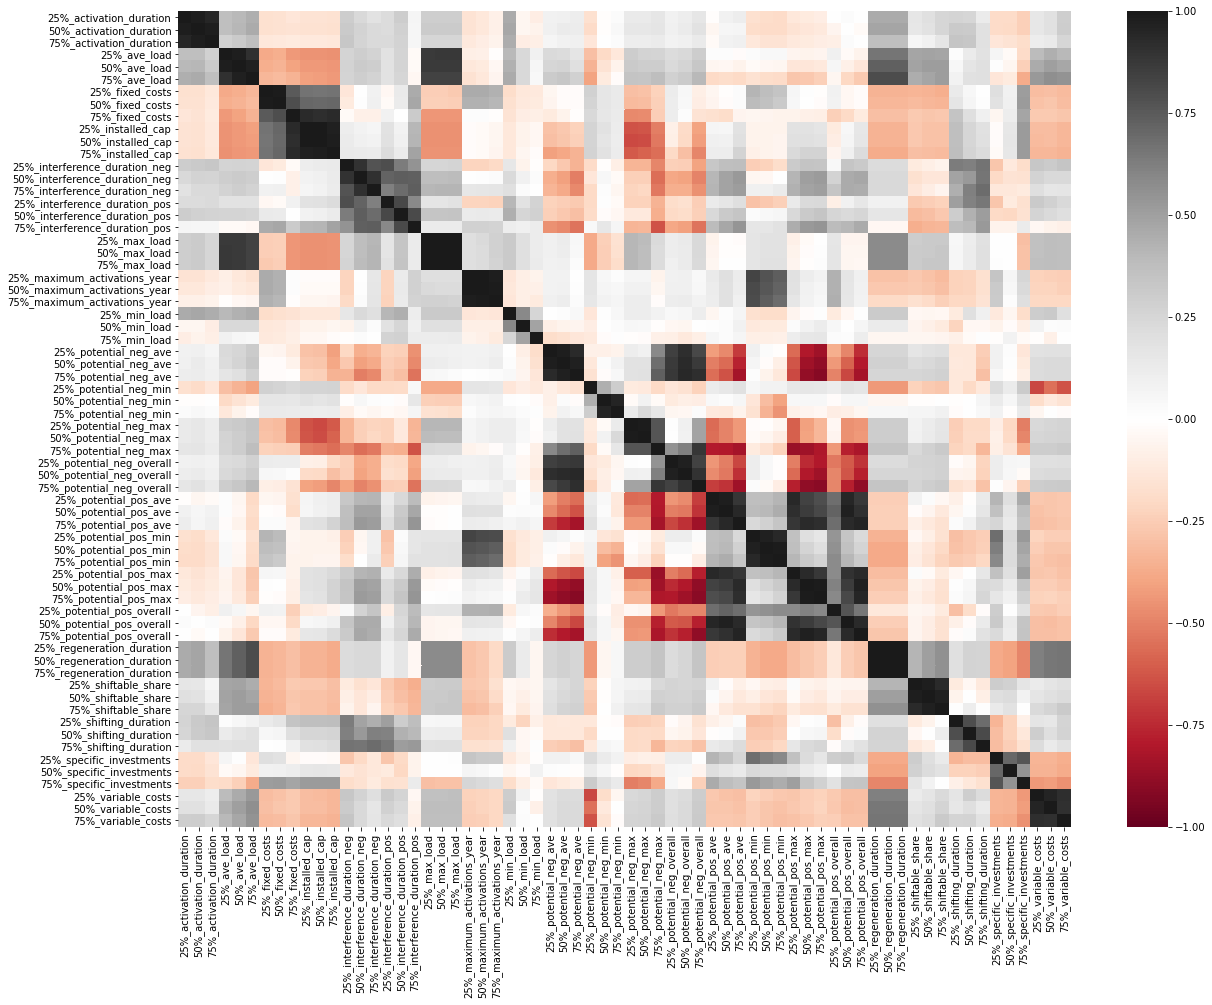

In [14]:
# Show heatmap for correlations
fig, ax = plt.subplots(figsize=(20, 15))
_ = sns.heatmap(corr_matrix, cmap="RdGy", vmin=-1.0, vmax=1.0)
plt.show()

## Create overall data set and interpolate missing values prior to clustering
Overview on approach used:
1. Create an **overall data set** and slice the parameters of interest.
2. Introduce **linear interpolation** for potential and cost parameters:
    * Potential parameters: The values for the status quo, 2030 and 2050 are used. Linear interpolation is made in between.
    * Cost parameters: The minimum cost value is assigned to 2050 since cost increases seem pretty unlikely. Linear interpolation is made between the status quo and 2050 (minimum cost value). Costs of zero are set to 0.01 in order to attribute cost to DR and prevent numeric effects disturbing DR utilization in the model.
3. **Assign remaining** parameters (mostly time-related ones) the same as for the status quo for every year.


> _Note: There is quite some room for **further improvements**._
> * _Development of positive and negative potentials should be in line with each other which doesn't have to be the case in the approach used._
> * _General trends in parameter development could be identified (increase / decrease / constant) by some other systematic like linear regression (some code snippets are kept, but not used for now here)._

### Create overall data set

In [15]:
# Introduce a DataFrame to store overall data for all years
potential_all_years = pd.DataFrame()
potential_all_years_nojoin = pd.DataFrame()

for year in years:
    potential_dict[year]["year_key"] = year
    potential_dict_nojoin[year]["year_key"] = year
    potential_all_years = pd.concat([potential_all_years, potential_dict[year]])
    potential_all_years_nojoin = pd.concat([potential_all_years_nojoin, potential_dict_nojoin[year]])

In [16]:
# Get all demand response categories
dr_cats = potential_all_years.index.unique().values

Only a **subset of the parameters** needs to be further analyzed:
* Time-dependent parameters are assumed constant. These comprise:
    * activation duration
    * interference duration (both pos and neg) and shifting duration
    * regeneration duration
* Other parameters are not really resp. not directly used in the modeling approaches for DR. These comprise:
    * average, minimum and maximum load
* This leads to the following remaining parameters focussing on costs and potentials. Since the correlation analysis showed high redundandencies for the potential parameters, only the following remaining parameters will be further analyzed:
    * potential positive overall
    * potential negative overall
    * installed capacity
    * fixed and variable costs
    * specific investments

In [17]:
dr_cats_nojoin = potential_all_years_nojoin.index.unique().values

### Linear interpolation for potential and costs data

In [18]:
# choose parameters for which some adaptions are needed
params_tbu_list = ["potential_neg_overall",
                   "potential_pos_overall",
                   "installed_cap",
                   "fixed_costs", "variable_costs", "specific_investments"]

params_tbu = create_parameter_combinations(params_tbu_list, cols)
params_tbu.append("year_key")

In [19]:
# Slice the parameter values needed
slice_pot = potential_all_years.loc[:,params_tbu]
slice_pot_nojoin = potential_all_years_nojoin.loc[:,params_tbu]
neg_pot_cols = create_parameter_combinations(["potential_neg_overall"], cols)
slice_pot[neg_pot_cols] = slice_pot[neg_pot_cols].mul(-1)
slice_pot_nojoin[neg_pot_cols] = slice_pot_nojoin[neg_pot_cols].mul(-1)

Perform **interpolation on potential and costs parameters** in order to
1. Fill data gaps and
2. remove inplausibilities such as potentials changing very strong and not consistent within the five year intervalls used.

In [20]:
# Define potential and cost cols
pot_cols = create_parameter_combinations(["potential_pos_overall", 
                                          "potential_neg_overall", 
                                          "installed_cap"], cols)
cost_cols = create_parameter_combinations(["specific_investments", 
                                           "fixed_costs", 
                                           "variable_costs"], cols)

# Instanciate new DataFrame to store manipulated outputs
slice_pot_new = pd.DataFrame(index=pd.MultiIndex.from_product([[],[],[]], 
                             names=["Prozess", "sector", "year_key"]))
slice_pot_new_nojoin = pd.DataFrame(index=pd.MultiIndex.from_product([[],[],[]], 
                                    names=["Prozess", "sector", "year_key"]))

# Create a list of DataFrames to concat
to_concat = [slice_pot_new]
to_concat_nojoin = [slice_pot_new_nojoin]

for el in dr_cats:
    df = slice_pot.loc[el].set_index("year_key", append=True)

    # Check potential values for interpolation
    pot_vals_SQ = df.loc[(el[0], el[1], "SQ"), pot_cols]
    try:
        pot_vals_2030 = df.loc[(el[0], el[1], "2030"), pot_cols]
    except:
        pot_vals_2030 = np.nan
    try:
        pot_vals_2050 = df.loc[(el[0], el[1], "2050"), pot_cols]
    except:
        pot_vals_2050 = pot_vals_SQ
    
    # Assign potential values for 2030 and 2050 and interpolate in between
    multi_ix = pd.MultiIndex.from_product([[el[0]], [el[1]], years], 
                                          names=["Prozess", "sector", "year_key"])
    new_df = pd.DataFrame(index=multi_ix)
    new_df.loc[(el[0], el[1], "SQ"), pot_cols] = pot_vals_SQ
    new_df.loc[(el[0], el[1], "2030"), pot_cols] = pot_vals_2030
    new_df.loc[(el[0], el[1], "2050"), pot_cols] = pot_vals_2050

    # Check cost values for interpolation
    cost_vals_SQ = df.loc[(el[0], el[1], "SQ"), cost_cols]     
    min_costs = df[cost_cols].min()

    # Assign minimum value for 2050 and interpolate in between
    new_df.loc[(el[0], el[1], "SQ"), cost_cols] = cost_vals_SQ.fillna(0.01)
    new_df.loc[(el[0], el[1], "2050"), cost_cols] = min_costs
    new_df[cost_cols] = new_df[cost_cols].replace({0: 0.01})
    new_df = new_df.interpolate()

    new_df = new_df.interpolate()
    to_concat.append(new_df)

slice_pot_new = pd.concat([el for el in to_concat], levels=([0, 1, 2]))    

# nojoin
for el in dr_cats_nojoin:
    df = slice_pot_nojoin.loc[el].set_index("year_key", append=True)

    # Check potential values for interpolation
    pot_vals_SQ = df.loc[(el[0], el[1], "SQ"), pot_cols]
    try:
        pot_vals_2030 = df.loc[(el[0], el[1], "2030"), pot_cols]
    except:
        pot_vals_2030 = np.nan
    try:
        pot_vals_2050 = df.loc[(el[0], el[1], "2050"), pot_cols]
    except:
        pot_vals_2050 = pot_vals_SQ
    
    # Assign potential values for 2030 and 2050 and interpolate in between
    multi_ix = pd.MultiIndex.from_product([[el[0]], [el[1]], years], 
                                          names=["Prozess", "sector", "year_key"])
    new_df = pd.DataFrame(index=multi_ix)
    new_df.loc[(el[0], el[1], "SQ"), pot_cols] = pot_vals_SQ
    new_df.loc[(el[0], el[1], "2030"), pot_cols] = pot_vals_2030
    new_df.loc[(el[0], el[1], "2050"), pot_cols] = pot_vals_2050

    # Check cost values for interpolation
    cost_vals_SQ = df.loc[(el[0], el[1], "SQ"), cost_cols]     
    min_costs = df[cost_cols].min()

    # Assign minimum value for 2050 and interpolate in between
    new_df.loc[(el[0], el[1], "SQ"), cost_cols] = cost_vals_SQ.fillna(0.01)
    new_df.loc[(el[0], el[1], "2050"), cost_cols] = min_costs
    new_df[cost_cols] = new_df[cost_cols].replace({0: 0.01})
    new_df = new_df.interpolate().round(2)
    
    new_df = new_df.interpolate()
    to_concat_nojoin.append(new_df)
    
slice_pot_new_nojoin = pd.concat([el for el in to_concat_nojoin], levels=([0, 1, 2]))  

<ipython-input-20-266019a16279>:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = slice_pot.loc[el].set_index("year_key", append=True)
<ipython-input-20-266019a16279>:58: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = slice_pot_nojoin.loc[el].set_index("year_key", append=True)


In [21]:
slice_pot_new[cost_cols].min()

25%_specific_investments    0.01
50%_specific_investments    0.01
75%_specific_investments    0.01
25%_fixed_costs             0.01
50%_fixed_costs             0.01
75%_fixed_costs             0.01
25%_variable_costs          0.01
50%_variable_costs          0.01
75%_variable_costs          0.01
dtype: float64

**Alternative trend analysis for DR parameters**:
> _NOTE: This section is work in progress and contains some open questions._<br>
> _It will be skipped for that reason (unless it is explicitly stated not to be skipped)._
* Potential parameters:
    * If $ r^2 \geq 0.8 $ &rarr; apply linear regression.
    * Use other approach yet to be defined...
* Cost parameters: Suitable approach yet to be defined...

In [22]:
# Alternative: use linear regression to analyze trends for dr categories
if not skip_dev:
    # "year_key" has to be an integer for that purpose
    slice_pot["year_key"] = slice_pot["year_key"].replace({"SQ": "2015"})
    slice_pot["year_key"] = slice_pot["year_key"].astype(int)
    
    for el in dr_cats:
        for pot_col in ["50%_potential_neg_overall", "50%_potential_pos_overall"]:
            slope, intercept, r_value, p_value, std_err = linregress(
                slice_pot.loc[el, "year_key"].values,
                slice_pot.loc[el, pot_col].values)
            if r_value ** 2 >= 0.8:
                slice_pot.loc[el, pot_col][slice_pot.loc[el, "year_key"] != 2015] \
                    = intercept + slope * slice_pot.loc[el, "year_key"]

        #plt.scatter(slice_pot.loc[el, "year_key"].values, 
        #            slice_pot.loc[el, pot_col].values)

### Assignment of remaining (time-related parameters)

In [23]:
# Assign remaining (mostly time-related) parameters
params_remaining_list = ["interference_duration_neg",
                         "interference_duration_pos", 
                         "maximum_activations_year", 
                         "regeneration_duration", 
                         "shifting_duration"]

params_remaining = create_parameter_combinations(params_remaining_list, cols)
params_remaining.append("year_key")

In [24]:
# Slice the parameter values needed
slice_pot = potential_all_years.loc[:,params_remaining]
slice_pot_nojoin = potential_all_years_nojoin.loc[:,params_remaining]
slice_pot.set_index("year_key", append=True, drop=False, inplace=True)
slice_pot_nojoin.set_index("year_key", append=True, drop=False, inplace=True)
params_remaining.remove("year_key")

In [25]:
slice_pot_new.loc[slice_pot_new.index.get_level_values(2) == "SQ", params_remaining] =\
    slice_pot.loc[slice_pot.index.get_level_values(2) == "SQ", params_remaining]
slice_pot_new.fillna(method="ffill", inplace=True)

slice_pot_new_nojoin.loc[slice_pot_new_nojoin.index.get_level_values(2) == "SQ", params_remaining] =\
    slice_pot_nojoin.loc[slice_pot_nojoin.index.get_level_values(2) == "SQ", params_remaining]
slice_pot_new_nojoin.fillna(method="ffill", inplace=True)

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


### Rearrange to dict-based data structure
> _NOTE: In general, this is not a necessity, but utilized here in order not to have to revert the entire ensuing clustering routine (which was initially build up upon the dict-based data structure)._

In [26]:
slice_pot_new = slice_pot_new.reset_index(level=2)
slice_pot_new_nojoin = slice_pot_new_nojoin.reset_index(level=2)

for year in years:
    potential_dict[year] = slice_pot_new[slice_pot_new["year_key"] == year].drop("year_key", axis=1)
    potential_dict_nojoin[year] = slice_pot_new_nojoin[slice_pot_new_nojoin["year_key"] == year].drop("year_key", axis=1)

In [27]:
potential_dict["SQ"].head()

,,25%_potential_pos_overall,50%_potential_pos_overall,75%_potential_pos_overall,25%_potential_neg_overall,50%_potential_neg_overall,75%_potential_neg_overall,25%_installed_cap,50%_installed_cap,75%_installed_cap,25%_specific_investments,...,75%_interference_duration_pos,25%_maximum_activations_year,50%_maximum_activations_year,75%_maximum_activations_year,25%_regeneration_duration,50%_regeneration_duration,75%_regeneration_duration,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration
Prozess,sector,,,,,,,,,,,,,,,,,,,,,
Primäraluminiumelektrolyse,ind,277.0,404.5,878.75,32.50,40.0,50.00,916.0,938.0,960.00,1.11,...,4.0,42.50,110.00,361.25,3.0,2.0,1.0,0.0,3.85,5.05
Chlor-Alkali-Elektrolyse,ind,477.0,575.0,730.00,-0.00,111.0,334.25,910.0,1370.0,1709.00,0.96,...,4.8,35.00,43.75,58.00,3.0,2.0,1.0,0.0,2.00,5.80
Holz- und Zellstoffherstellung,ind,217.0,250.0,311.00,64.50,84.0,164.25,292.0,324.0,418.75,11.42,...,4.3,20.00,52.00,650.00,3.0,2.0,1.0,4.0,7.80,10.80
Papiermaschinen,ind,180.5,1012.5,1636.25,87.50,111.0,123.25,1412.0,1836.0,1976.74,2.72,...,5.2,5.00,65.00,323.75,3.0,2.0,1.0,6.6,11.20,11.20
Elektrostahlherstellung (Lichtbogenofen),ind,741.0,931.0,1098.00,158.75,327.0,610.00,1107.0,1730.0,2120.00,1.11,...,4.0,23.75,45.00,73.00,3.0,2.0,1.0,0.0,1.00,2.68


In [28]:
potential_dict_nojoin["2050"].tail()

,,25%_potential_pos_overall,50%_potential_pos_overall,75%_potential_pos_overall,25%_potential_neg_overall,50%_potential_neg_overall,75%_potential_neg_overall,25%_installed_cap,50%_installed_cap,75%_installed_cap,25%_specific_investments,...,75%_interference_duration_pos,25%_maximum_activations_year,50%_maximum_activations_year,75%_maximum_activations_year,25%_regeneration_duration,50%_regeneration_duration,75%_regeneration_duration,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration
Prozess,sector,,,,,,,,,,,,,,,,,,,,,
Kühlung (Lebensmittelindustrie),ind,150.65,200.0,314.22,52.18,67.34,115.74,480.34,528.28,576.22,1.17,...,4.0,23.75,52.0,323.75,3.0,2.0,1.0,4.0,6.0,15.0
Warmwasserbereitstellung,tcs,53.40,94.0,306.46,64.78,127.43,232.26,1150.59,1366.49,1582.39,0.01,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,2.5,6.0,11.0
Prozesskälte Handel,tcs,0.00,0.0,0.00,234.50,389.00,537.00,0.00,0.00,0.00,0.01,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Prozesswärme,tcs,544.50,982.0,1004.50,1333.00,1963.00,2009.00,0.00,0.00,0.00,0.01,...,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Luftzerlegung,ind,150.65,200.0,314.22,52.18,67.34,115.74,480.34,528.28,576.22,1.17,...,4.0,23.75,52.0,323.75,3.0,2.0,1.0,4.0,4.0,24.0


# Cluster data
* Do a clustering using K-Means and the cluster parameters defined in the above parameter settings (alternative: agglomerative clustering using ward linkage).
* Default: Cluster within sectors by shifting times, positive interference duration, variable costs as well as specific investments

## Do the actual clustering
* Create a list of the cluster parameters
* Determine the number of clusters per sector
* Perform a K-Means clustering on the data (alternative: agglomerative clustering using ward linkage)

In [29]:
cluster_parameters_list = create_parameter_combinations(cluster_parameters, ["50%"])
cluster_parameters_list

['50%_shifting_duration',
 '50%_interference_duration_pos',
 '50%_variable_costs',
 '50%_fixed_costs',
 '50%_specific_investments']

In [30]:
# Initialize the column to store the cluster label
potential_dict["SQ"]["cluster"] = 0

print(f"Number of clusters for {cluster_algo} clustering")

# Increase cluster numbers by (arbitratily chosen) increments
# in order not to overwrite cluster information
iter = 0
increments = [1000, 100, 10, 1]

# Iterate over the sectors and create clusters within the sectors
for sector in potential_dict["SQ"].index.get_level_values(1).unique():
    # Determine the number of clusters per sector and print it
    n = math.ceil(potential_dict["SQ"][potential_dict["SQ"].index.get_level_values(1) == sector].shape[0]*share_clusters)
    print(sector+":\t\t"+str(n))
    
    if cluster_algo == "KMeans":
        # Do the actual clustering and assign the cluster labels
        #display(potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector])
        potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, "cluster"] = \
            KMeans(n_clusters=n).fit(
                potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, 
                                         cluster_parameters_list].values).labels_ + 1
        
    elif cluster_algo == "ward":
        # Do the actual clustering and assign the cluster labels
        potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, "cluster"] = \
            AgglomerativeClustering(n_clusters=n, linkage="ward").fit(
                potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector, cluster_parameters_list].values).labels_ + 1       

    # Increment the cluster labels to avoid overwriting in the next iteration (K-Means always starts with zero)
    potential_dict["SQ"].loc[potential_dict["SQ"]["cluster"] != 0, "cluster"] += n * increments[iter]
    iter += 1
    #display(potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == sector])

Number of clusters for KMeans clustering
ind:		2
tcs+hoho:		1
tcs:		1
hoho:		1


In [31]:
# Print the number of unique cluster labels (cross check)
potential_dict["SQ"]["cluster"].nunique()

5

**Cluster assignment**:
* Assign cluster information for future years (_Note: simple assignment does an index mapping_).
* Furthermore, assing cluster information to data set in which tcs and hoho applications haven't been joined.

In [32]:
for year in years:
    if not year == "SQ":
        potential_dict[year]["cluster"] = potential_dict["SQ"]["cluster"]
        
    # Add cluster information for data not joined
    potential_dict_nojoin[year]["cluster"] = potential_dict[year]["cluster"]

    # Add cluster information for categories for which it is missing, i.e. categories in tcs+hoho sector
    # Determine indices to use for selecting cluster numbers
    no_cluster_ixs = list(set(potential_dict_nojoin[year][
        potential_dict_nojoin[year]["cluster"].isna()].index.get_level_values(0)))
    no_cluster_ixs = [(i, j) for i in no_cluster_ixs for j in ["tcs+hoho"]]

    # Use only the first index level to be able to assign values (second index levels won't match)
    clusters_to_use = potential_dict[year].loc[no_cluster_ixs, "cluster"].to_frame()
    clusters_to_use = clusters_to_use.set_index(clusters_to_use.index.get_level_values(0))

    # Use an excerpt of the overall DataFrame to assign the cluster info
    excerpt = potential_dict_nojoin[year].loc[potential_dict_nojoin[year]["cluster"].isna(),"cluster"].to_frame()
    excerpt = excerpt.reset_index().set_index("Prozess")
    excerpt["cluster"] = clusters_to_use["cluster"]
    excerpt = excerpt.set_index("sector", append=True)
    potential_dict_nojoin[year].loc[potential_dict_nojoin[year]["cluster"].isna(),"help_sector"] = "tcs+hoho"
    potential_dict_nojoin[year].loc[potential_dict_nojoin[year]["cluster"].isna(),"cluster"] = excerpt.loc[:,"cluster"]

In [33]:
potential_dict["2050"].head()

,,25%_potential_pos_overall,50%_potential_pos_overall,75%_potential_pos_overall,25%_potential_neg_overall,50%_potential_neg_overall,75%_potential_neg_overall,25%_installed_cap,50%_installed_cap,75%_installed_cap,25%_specific_investments,...,25%_maximum_activations_year,50%_maximum_activations_year,75%_maximum_activations_year,25%_regeneration_duration,50%_regeneration_duration,75%_regeneration_duration,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration,cluster
Prozess,sector,,,,,,,,,,,,,,,,,,,,,
Primäraluminiumelektrolyse,ind,150.65,200.00,606.55,24.50,28.00,31.50,648.90,656.60,664.30,0.01,...,42.50,110.00,361.25,3.0,2.0,1.0,0.0,3.85,5.05,2112
Chlor-Alkali-Elektrolyse,ind,323.60,393.00,572.93,85.45,118.55,151.65,1203.12,1303.41,1403.71,0.25,...,35.00,43.75,58.00,3.0,2.0,1.0,0.0,2.00,5.80,2112
Holz- und Zellstoffherstellung,ind,123.02,196.59,223.48,52.18,67.34,115.74,242.52,305.76,369.00,1.27,...,20.00,52.00,650.00,3.0,2.0,1.0,4.0,7.80,10.80,2112
Papiermaschinen,ind,1028.95,1589.62,2064.16,153.02,190.20,231.97,1884.00,2216.84,2549.68,2.72,...,5.00,65.00,323.75,3.0,2.0,1.0,6.6,11.20,11.20,2112
Elektrostahlherstellung (Lichtbogenofen),ind,447.50,1038.00,1134.00,63.50,127.00,190.50,2120.00,2120.00,2120.00,0.69,...,23.75,45.00,73.00,3.0,2.0,1.0,0.0,1.00,2.68,2112


In [34]:
potential_dict["SQ"].head()

,,25%_potential_pos_overall,50%_potential_pos_overall,75%_potential_pos_overall,25%_potential_neg_overall,50%_potential_neg_overall,75%_potential_neg_overall,25%_installed_cap,50%_installed_cap,75%_installed_cap,25%_specific_investments,...,25%_maximum_activations_year,50%_maximum_activations_year,75%_maximum_activations_year,25%_regeneration_duration,50%_regeneration_duration,75%_regeneration_duration,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration,cluster
Prozess,sector,,,,,,,,,,,,,,,,,,,,,
Primäraluminiumelektrolyse,ind,277.0,404.5,878.75,32.50,40.0,50.00,916.0,938.0,960.00,1.11,...,42.50,110.00,361.25,3.0,2.0,1.0,0.0,3.85,5.05,2112
Chlor-Alkali-Elektrolyse,ind,477.0,575.0,730.00,-0.00,111.0,334.25,910.0,1370.0,1709.00,0.96,...,35.00,43.75,58.00,3.0,2.0,1.0,0.0,2.00,5.80,2112
Holz- und Zellstoffherstellung,ind,217.0,250.0,311.00,64.50,84.0,164.25,292.0,324.0,418.75,11.42,...,20.00,52.00,650.00,3.0,2.0,1.0,4.0,7.80,10.80,2112
Papiermaschinen,ind,180.5,1012.5,1636.25,87.50,111.0,123.25,1412.0,1836.0,1976.74,2.72,...,5.00,65.00,323.75,3.0,2.0,1.0,6.6,11.20,11.20,2112
Elektrostahlherstellung (Lichtbogenofen),ind,741.0,931.0,1098.00,158.75,327.0,610.00,1107.0,1730.0,2120.00,1.11,...,23.75,45.00,73.00,3.0,2.0,1.0,0.0,1.00,2.68,2112


## Show and explore the clusters
Print the clusters in order to visually inspect them

In [35]:
if print_clusters:
    for el in np.sort(potential_dict["SQ"]["cluster"].unique()):
        print(20 * "-")
        print("cluster number: "+str(el))
        print(20 * "-")
        display(potential_dict["SQ"][potential_dict["SQ"]["cluster"] == el])

--------------------
cluster number: 2
--------------------


,,25%_potential_pos_overall,50%_potential_pos_overall,75%_potential_pos_overall,25%_potential_neg_overall,50%_potential_neg_overall,75%_potential_neg_overall,25%_installed_cap,50%_installed_cap,75%_installed_cap,25%_specific_investments,...,25%_maximum_activations_year,50%_maximum_activations_year,75%_maximum_activations_year,25%_regeneration_duration,50%_regeneration_duration,75%_regeneration_duration,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration,cluster
Prozess,sector,,,,,,,,,,,,,,,,,,,,,
Kühlschränke,hoho,924.81,1317.16,1809.22,-0.0,-0.00,500.00,3872.00,4103.0,4527.43,1325.34,...,4380.00,6570.0,7665.00,0.0,0.0,0.0,0.40,0.50,3.00,2
Geschirrspüler,hoho,0.00,0.00,470.57,-0.0,484.82,1986.87,52151.00,52232.0,62614.50,94.82,...,211.50,266.0,301.00,0.0,0.0,0.0,10.50,18.00,19.50,2
Wäschetrockner,hoho,0.00,0.00,143.65,-0.0,359.32,1436.52,35381.75,35700.5,57159.75,94.82,...,123.00,152.0,172.00,0.0,0.0,0.0,3.50,3.50,4.70,2
Waschmaschinen,hoho,0.00,16.54,265.14,-0.0,380.36,2121.15,66012.00,66149.0,66286.00,94.82,...,198.00,220.0,242.00,0.0,0.0,0.0,3.50,3.50,5.35,2
Gefrierschränke und -truhen,hoho,548.13,780.49,1071.85,-0.0,-0.00,360.00,2294.50,2431.0,3671.07,352.63,...,4380.00,6570.0,7665.00,0.0,0.0,0.0,0.40,0.50,3.00,2
Heizungsumwälzpumpen,hoho,615.60,1894.69,2716.18,-0.0,-0.00,642.60,2262.50,2500.0,2737.50,2577.74,...,355.75,383.5,575.25,0.0,0.0,0.0,0.25,0.35,0.48,2
Kühl- und Gefrierkombinationen,hoho,500.00,980.00,980.00,500.0,980.00,980.00,0.00,0.0,0.00,0.01,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,2


--------------------
cluster number: 12
--------------------


,,25%_potential_pos_overall,50%_potential_pos_overall,75%_potential_pos_overall,25%_potential_neg_overall,50%_potential_neg_overall,75%_potential_neg_overall,25%_installed_cap,50%_installed_cap,75%_installed_cap,25%_specific_investments,...,25%_maximum_activations_year,50%_maximum_activations_year,75%_maximum_activations_year,25%_regeneration_duration,50%_regeneration_duration,75%_regeneration_duration,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration,cluster
Prozess,sector,,,,,,,,,,,,,,,,,,,,,
Prozesskälte,tcs,160.00,206.73,273.26,51.32,81.43,130.50,1875.50,2234.0,2554.75,1040.08,...,328.50,365.0,401.50,0.0,0.0,0.0,0.50,0.5,1.00,12
Belüftung,tcs,46.71,80.22,164.11,18.45,54.17,123.07,915.50,1077.0,1238.50,1200.00,...,346.75,365.0,438.00,0.0,0.0,0.0,0.00,0.0,0.00,12
Pumpenanwendungen in der Wasserversorgung,tcs,173.92,290.00,425.42,135.28,290.00,502.78,334.00,773.0,1160.00,0.01,...,346.50,365.0,402.00,0.0,0.0,0.0,4.00,9.0,10.50,12
Beleuchtung,tcs,0.00,2.41,9.09,-0.00,4.44,7.86,15.70,19.4,23.10,0.01,...,225.00,243.0,261.00,0.0,0.0,0.0,2.40,3.0,8.55,12
Zerkleinerer,tcs,15.93,21.60,32.30,8.37,13.68,20.09,32.50,38.0,43.50,0.01,...,337.25,365.0,392.75,0.0,0.0,0.0,6.55,8.5,13.35,12
Abwasserbehandlung,tcs,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.0,0.00,423.22,...,0.00,0.0,0.00,0.0,0.0,0.0,2.00,2.0,4.00,12
Kühlhäuser,tcs,0.00,81.00,230.00,24.75,147.00,198.75,126.75,184.5,217.75,0.01,...,0.00,0.0,0.00,0.0,0.0,0.0,2.00,2.0,3.00,12
Prozesskälte Handel,tcs,0.00,0.00,0.00,234.50,389.00,537.00,0.00,0.0,0.00,0.01,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,12
Prozesswärme,tcs,544.50,982.00,1004.50,1333.00,1963.00,2009.00,0.00,0.0,0.00,0.01,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,12


--------------------
cluster number: 112
--------------------


,,25%_potential_pos_overall,50%_potential_pos_overall,75%_potential_pos_overall,25%_potential_neg_overall,50%_potential_neg_overall,75%_potential_neg_overall,25%_installed_cap,50%_installed_cap,75%_installed_cap,25%_specific_investments,...,25%_maximum_activations_year,50%_maximum_activations_year,75%_maximum_activations_year,25%_regeneration_duration,50%_regeneration_duration,75%_regeneration_duration,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration,cluster
Prozess,sector,,,,,,,,,,,,,,,,,,,,,
Wärmepumpen,tcs+hoho,447.77,691.00,989.66,120.00,403.04,1067.23,1660.00,2269.5,2879.75,8.91,...,591.00,639.0,687.0,0.0,0.0,0.0,2.42,3.00,3.60,112
Nachtspeicherheizungen,tcs+hoho,912.25,2815.00,7439.54,3182.25,6542.50,9407.75,17275.00,17950.0,34500.00,35.36,...,144.00,160.0,176.0,0.0,0.0,0.0,4.23,7.55,17.50,112
Warmwasserbereitstellung,tcs+hoho,683.75,3580.00,5336.48,776.50,1494.00,6404.56,18605.75,21445.5,21902.25,475.00,...,355.75,365.0,402.0,0.0,0.0,0.0,5.00,9.00,17.50,112
Klimakälte,tcs+hoho,152.03,1505.92,4266.14,61.35,863.15,2514.30,8894.00,9373.0,9595.00,422.13,...,319.25,365.0,420.0,0.0,0.0,0.0,0.36,0.38,0.76,112


--------------------
cluster number: 2112
--------------------


,,25%_potential_pos_overall,50%_potential_pos_overall,75%_potential_pos_overall,25%_potential_neg_overall,50%_potential_neg_overall,75%_potential_neg_overall,25%_installed_cap,50%_installed_cap,75%_installed_cap,25%_specific_investments,...,25%_maximum_activations_year,50%_maximum_activations_year,75%_maximum_activations_year,25%_regeneration_duration,50%_regeneration_duration,75%_regeneration_duration,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration,cluster
Prozess,sector,,,,,,,,,,,,,,,,,,,,,
Primäraluminiumelektrolyse,ind,277.00,404.50,878.75,32.50,40.00,50.00,916.0,938.0,960.00,1.11,...,42.50,110.00,361.25,3.0,2.0,1.0,0.0,3.85,5.05,2112
Chlor-Alkali-Elektrolyse,ind,477.00,575.00,730.00,-0.00,111.00,334.25,910.0,1370.0,1709.00,0.96,...,35.00,43.75,58.00,3.0,2.0,1.0,0.0,2.00,5.80,2112
Holz- und Zellstoffherstellung,ind,217.00,250.00,311.00,64.50,84.00,164.25,292.0,324.0,418.75,11.42,...,20.00,52.00,650.00,3.0,2.0,1.0,4.0,7.80,10.80,2112
Papiermaschinen,ind,180.50,1012.50,1636.25,87.50,111.00,123.25,1412.0,1836.0,1976.74,2.72,...,5.00,65.00,323.75,3.0,2.0,1.0,6.6,11.20,11.20,2112
Elektrostahlherstellung (Lichtbogenofen),ind,741.00,931.00,1098.00,158.75,327.00,610.00,1107.0,1730.0,2120.00,1.11,...,23.75,45.00,73.00,3.0,2.0,1.0,0.0,1.00,2.68,2112
Zementherstellung,ind,209.25,313.00,332.75,105.00,174.00,270.00,347.5,397.0,479.00,20.05,...,36.25,50.00,137.50,3.0,2.0,1.0,4.2,21.40,24.00,2112
Altpapierrecycling (Pulper),ind,395.50,449.00,519.00,83.50,123.00,293.75,469.0,592.5,743.25,2.72,...,5.00,65.00,1598.75,3.0,2.0,1.0,4.0,4.30,5.90,2112
Belüftung,ind,5.54,11.97,35.16,8.23,14.30,27.68,308.0,374.0,420.00,221.81,...,346.75,365.00,438.00,3.0,2.0,1.0,4.0,5.15,6.55,2112
Prozesskälte,ind,220.80,281.00,359.68,193.20,239.12,302.18,460.0,562.0,664.00,2.72,...,310.25,365.00,419.75,3.0,2.0,1.0,4.0,5.15,6.55,2112


--------------------
cluster number: 2113
--------------------


,,25%_potential_pos_overall,50%_potential_pos_overall,75%_potential_pos_overall,25%_potential_neg_overall,50%_potential_neg_overall,75%_potential_neg_overall,25%_installed_cap,50%_installed_cap,75%_installed_cap,25%_specific_investments,...,25%_maximum_activations_year,50%_maximum_activations_year,75%_maximum_activations_year,25%_regeneration_duration,50%_regeneration_duration,75%_regeneration_duration,25%_shifting_duration,50%_shifting_duration,75%_shifting_duration,cluster
Prozess,sector,,,,,,,,,,,,,,,,,,,,,
Kupfer- und Zinkherstellung (Elektrolyse),ind,0.00,5.0,90.75,-0.00,-0.0,7.00,0.0,177.0,182.0,0.01,...,10.0,40.0,50.0,3.0,2.0,1.0,0.00,4.0,6.9,2113
Gießereien (Induktionsofen),ind,72.00,115.0,158.00,14.00,25.0,36.00,96.5,148.0,199.5,10.69,...,0.0,20.0,50.0,3.0,2.0,1.0,5.18,6.0,6.0,2113
Calciumcarbid-Herstellung (Lichtbogenofen),ind,32.25,51.0,69.00,9.75,13.0,15.75,67.0,78.0,89.0,9.41,...,5.0,35.0,72.5,3.0,2.0,1.0,4.80,6.0,6.2,2113


## Create transposed potential data sets for combining it with availability data

In [36]:
# Initialize dicts to store the transposed (and not joined) potential data
# as well as the availability time series
potential_T_dict = {}
potential_ind_T_dict = {}
potential_tcs_T_dict = {}
potential_hoho_T_dict = {}
potential_tcs_hoho_T_dict = {}

for year in years:
    # Create transposed subsets of potential_dict_nojoin
    potential_T_dict[year] = potential_dict_nojoin[year].T
    potential_ind_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "ind"].T
    potential_tcs_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "tcs"].T
    potential_hoho_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "hoho"].T
    potential_tcs_hoho_T_dict[year] = potential_dict_nojoin[year][
        potential_dict_nojoin[year].index.get_level_values(1) == "tcs+hoho"].T

In [37]:
potential_T_dict["SQ"].head()

Prozess,Primäraluminiumelektrolyse,Chlor-Alkali-Elektrolyse,Holz- und Zellstoffherstellung,Papiermaschinen,Elektrostahlherstellung (Lichtbogenofen),Zementherstellung,Kupfer- und Zinkherstellung (Elektrolyse),Altpapierrecycling (Pulper),Gießereien (Induktionsofen),Calciumcarbid-Herstellung (Lichtbogenofen),...,Beleuchtung,Druckluftanwendungen,Pumpenanwendungen,Nachtspeicherheizungen,Kühl- und Gefrierkombinationen,Kühlung (Lebensmittelindustrie),Warmwasserbereitstellung,Prozesskälte Handel,Prozesswärme,Luftzerlegung
sector,ind,ind,ind,ind,ind,ind,ind,ind,ind,ind,...,ind,ind,ind,tcs,hoho,ind,tcs,tcs,tcs,ind
25%_potential_pos_overall,277,477,217,180.5,741,209.25,0,395.5,72,32.25,...,209.25,167.78,209.25,741.75,500,273.75,241.5,0,544.5,209.25
50%_potential_pos_overall,404.5,575,250,1012.5,931,313,5,449,115,51,...,313,910.85,313,1161,980,362.5,370,0,982,313
75%_potential_pos_overall,878.75,730,311,1636.25,1098,332.75,90.75,519,158,69,...,359.68,1698.5,359.68,1832.25,980,480,417.5,0,1004.5,359.68
25%_potential_neg_overall,32.5,-0,64.5,87.5,158.75,105,-0,83.5,14,9.75,...,64.5,80.75,64.5,3182.25,500,352.5,602.5,234.5,1333,64.5
50%_potential_neg_overall,40,111,84,111,327,174,-0,123,25,13,...,111,1045.5,111,6542.5,980,450,740,389,1963,111


In [38]:
potential_T_dict["2050"].head()

Prozess,Primäraluminiumelektrolyse,Chlor-Alkali-Elektrolyse,Holz- und Zellstoffherstellung,Papiermaschinen,Elektrostahlherstellung (Lichtbogenofen),Zementherstellung,Kupfer- und Zinkherstellung (Elektrolyse),Altpapierrecycling (Pulper),Gießereien (Induktionsofen),Calciumcarbid-Herstellung (Lichtbogenofen),...,Beleuchtung,Druckluftanwendungen,Pumpenanwendungen,Nachtspeicherheizungen,Kühl- und Gefrierkombinationen,Kühlung (Lebensmittelindustrie),Warmwasserbereitstellung,Prozesskälte Handel,Prozesswärme,Luftzerlegung
sector,ind,ind,ind,ind,ind,ind,ind,ind,ind,ind,...,ind,ind,ind,tcs,hoho,ind,tcs,tcs,tcs,ind
25%_potential_pos_overall,150.65,323.6,123.02,1028.95,447.5,193.39,0,755.3,72,20.47,...,209.25,167.78,209.25,787.5,500,150.65,53.4,0,544.5,150.65
50%_potential_pos_overall,200,393,196.59,1589.62,1038,216.72,15,898.17,115,32.64,...,313,910.85,313,1575,980,200,94,0,982,200
75%_potential_pos_overall,606.55,572.93,223.48,2064.16,1134,314.22,145.23,1004.13,158,44.16,...,359.68,1698.5,359.68,1746.5,980,314.22,306.46,0,1004.5,314.22
25%_potential_neg_overall,24.5,85.45,52.18,153.02,63.5,68.54,-0,82.01,14,6.24,...,64.5,80.75,64.5,4603,500,52.18,64.78,234.5,1333,52.18
50%_potential_neg_overall,28,118.55,67.34,190.2,127,85.68,3.29,134.59,25,7.84,...,111,1045.5,111,9206,980,67.34,127.43,389,1963,67.34


## Read in and match availability data

* Read in the availability time series data.
* Match the data to the respective demand response categories.
        
> __*Conceptual question:*__ 
> _Rethink, whether availability timeseries indexed by year do make sense and how this should be handled within (investment) model runs._
> * _Pros: Different years (e.g. temperature or weekday patterns) could be depicted._
> * _Cons: Some effort has to be made to achieve that_

In [39]:
# Read in availability time series data
availability_ind_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "ind_pos", header=0, index_col=0)

availability_ind_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "ind_neg", header=0, index_col=0)

availability_tcs_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "tcs_pos", header=0, index_col=0)

availability_tcs_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "tcs_neg", header=0, index_col=0)

availability_hoho_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "hoho_pos", header=0, index_col=0)

availability_hoho_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "hoho_neg", header=0, index_col=0)

In [40]:
# Map the demand response categories to the column names used
# for the availability time series (naming conventions from the bachelor theses are widely used).
availability_cats_ind_pos = {'normiertes\nLRP Alu': ('Primäraluminiumelektrolyse', 'ind'),
                            'normiertes\nLRP CHL': ('Chlor-Alkali-Elektrolyse', 'ind'),
                            'normiertes\nLRP HS': ('Holz- und Zellstoffherstellung', 'ind'),
                            'normiertes\nLRP PM': ('Papiermaschinen', 'ind'),
                            'normiertes\nLRP ES': ('Elektrostahlherstellung (Lichtbogenofen)', 'ind'),
                            'normiertes\nLRP RZM': ('Zementherstellung', 'ind'),
                            'normiertes\nLRP KUZI': ('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind'),
                            'normiertes\nLRP AP': ('Altpapierrecycling (Pulper)', 'ind')}

availability_cats_ind_neg = {'normiertes\nLZP Alu': ('Primäraluminiumelektrolyse', 'ind'),
                            'normiertes\nLZP CHL': ('Chlor-Alkali-Elektrolyse', 'ind'),
                            'normiertes\nLZP HS': ('Holz- und Zellstoffherstellung', 'ind'),
                            'normiertes\nLZP PM': ('Papiermaschinen', 'ind'),
                            'normiertes\nLZP ES': ('Elektrostahlherstellung (Lichtbogenofen)', 'ind'),
                            'normiertes\nLZP RZM': ('Zementherstellung', 'ind'),
                            'normiertes\nLZP KUZI': ('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind'),
                            'normiertes\nLZP AP': ('Altpapierrecycling (Pulper)', 'ind')}

# Note: Instead of KGR in the tcs sector, profiles for food retailing are introduced and used.
availability_cats_tcs_pos = {'Lastabschaltung LÜ normiert': ('Belüftung', 'tcs'), 
                            'Lastabschaltung WVP normiert': ('Pumpenanwendungen in der Wasserversorgung', 'tcs'),
                            'Lastabschaltung KGR normiert': ('Prozesskälte Handel', 'tcs'),
                            'Lastabschaltung KÜ normiert': ('Kühlhäuser', 'tcs'),
                            'Lastabschaltung KA normiert': ('Klimakälte', 'tcs'),  
                            'Lastabschaltung EH normiert': ('Nachtspeicherheizungen', 'tcs'),
                            'Lastabschaltung WP normiert': ('Wärmepumpen', 'tcs'), 
                            'Lastabschaltung WW normiert': ('Warmwasserbereitstellung', 'tcs')}

availability_cats_tcs_neg = {'Lastzuschaltung LÜ normiert': ('Belüftung', 'tcs'),
                             'Lastzuschaltung WVP normiert': ('Pumpenanwendungen in der Wasserversorgung', 'tcs'),
                             'Lastzuschaltung KGR normiert': ('Prozesskälte Handel', 'tcs'),
                             'Lastzuschaltung KÜ normiert': ('Kühlhäuser', 'tcs'),
                             'Lastzuschaltung KA normiert': ('Klimakälte', 'tcs'), 
                             'Lastzuschaltung EH normiert': ('Nachtspeicherheizungen', 'tcs'),
                             'Lastzuschaltung WP normiert': ('Wärmepumpen', 'tcs'), 
                             'Lastzuschaltung WW normiert': ('Warmwasserbereitstellung', 'tcs')}

availability_cats_hoho_pos = {'Lastabschaltung KGR': ('Kühlschränke', 'hoho'), 
                              'Lastabschaltung WM': ('Waschmaschinen', 'hoho'), 
                              'Lastabschaltung WT': ('Wäschetrockner', 'hoho'),
                              'Lastabschaltung GS': ('Geschirrspüler', 'hoho'), 
                              'Lastabschaltung NH normiert': ('Nachtspeicherheizungen', 'hoho'),
                              'Lastabschaltung WP normiert': ('Wärmepumpen', 'hoho'), 
                              'Lastabschaltung UP': ('Heizungsumwälzpumpen', 'hoho'),
                              'Lastabschaltung RK': ('Klimakälte', 'hoho'), 
                              'Lastabschaltung WW Tag': ('Warmwasserbereitstellung', 'hoho')}

availability_cats_hoho_neg = {'Lastzuschaltung KGR normiert': ('Kühlschränke', 'hoho'),
                              'Lastzuschaltung WM normiert': ('Waschmaschinen', 'hoho'),
                              'Lastzuschaltung WT normiert': ('Wäschetrockner', 'hoho'),
                              'Lastzuschaltung GS normiert': ('Geschirrspüler', 'hoho'), 
                              'Lastzuschaltung NH normiert': ('Nachtspeicherheizungen', 'hoho'),
                              'Lastzuschaltung WP normiert': ('Wärmepumpen', 'hoho'),
                              'Lastzuschaltung RK': ('Klimakälte', 'hoho'), 
                              'Lastzuschaltung WW normiert Tag': ('Warmwasserbereitstellung', 'hoho')}


# Change column name of availability time series DataFrame
availability_ind_pos = map_column_names(availability_ind_pos, availability_cats_ind_pos)
availability_ind_neg = map_column_names(availability_ind_neg, availability_cats_ind_neg)
availability_tcs_pos = map_column_names(availability_tcs_pos, availability_cats_tcs_pos)
availability_tcs_neg = map_column_names(availability_tcs_neg, availability_cats_tcs_neg)
availability_hoho_pos = map_column_names(availability_hoho_pos, availability_cats_hoho_pos)
availability_hoho_neg = map_column_names(availability_hoho_neg, availability_cats_hoho_neg)

> __*Important TODO for availability: Improve proxies for availability!*__

## Create availability time series for demand response categories for which availability info is missing

In general, there are three options for filling up the missing availability information:
1. Assign the existing availability time series of another process / demand response category due to large similarities (assumed).
2. Assign a constant availability profile for the entire year.
3. Create a synthetic load profile by defining availability factors for hours, weekdays and months and combining them.
    
The folowing availability information is used:
* Industry sector:
    * Foundries (German: "Gießereien") will be assigned the value for copper and zinc.
    * Calcium carbide will be assigned the value for electric furnace steel.
    * For the remaining categories, no profiles are available. As a first proxy, a constant availability profile is assumed.
* Tcs sector:
    * In the first place, for all categories not covered, a constant availability profile is assumed. _&rarr; Needs to be changed!_
* Household sector:
    * fride-freezer combinations as well as freezers will be assigned the same profile as fridges.
    * For all remaining categories not covered, a constant availability profile is assumed. _&rarr; Needs to be changed!_

### Use availability time series of existing categories

In [41]:
# Boadcast values from existing demand response categories

# Industry sector
availability_ind_pos[('Calciumcarbid-Herstellung (Lichtbogenofen)', 'ind')] = \
    availability_ind_pos[('Elektrostahlherstellung (Lichtbogenofen)', 'ind')]
availability_ind_pos[('Gießereien (Induktionsofen)', 'ind')] = \
    availability_ind_pos[('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind')]

availability_ind_neg[('Calciumcarbid-Herstellung (Lichtbogenofen)', 'ind')] = \
    availability_ind_neg[('Elektrostahlherstellung (Lichtbogenofen)', 'ind')]
availability_ind_neg[('Gießereien (Induktionsofen)', 'ind')] = \
    availability_ind_neg[('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind')]

# tcs
availability_tcs_pos[('Prozesskälte', 'tcs')] =\
   availability_tcs_pos[('Kühlhäuser', 'tcs')] 
availability_tcs_neg[('Prozesskälte', 'tcs')] =\
   availability_tcs_neg[('Kühlhäuser', 'tcs')] 

# households
availability_hoho_pos[('Kühl- und Gefrierkombinationen', 'hoho')] = \
    availability_hoho_pos[('Kühlschränke', 'hoho')]
availability_hoho_pos[('Gefrierschränke und -truhen', 'hoho')] = \
    availability_hoho_pos[('Kühlschränke', 'hoho')]

availability_hoho_neg[('Kühl- und Gefrierkombinationen', 'hoho')] = \
    availability_hoho_neg[('Kühlschränke', 'hoho')]
availability_hoho_neg[('Gefrierschränke und -truhen', 'hoho')] = \
    availability_hoho_neg[('Kühlschränke', 'hoho')]

In [42]:
# Determine for which categories availability time series are still missing
determine_missing_cols(potential_ind_T_dict["SQ"], availability_ind_pos, sector="industry (positive)")
determine_missing_cols(potential_ind_T_dict["SQ"], availability_ind_neg, sector="industry (negative)")
determine_missing_cols(potential_tcs_T_dict["SQ"], availability_tcs_pos, sector="tcs (positive)")
determine_missing_cols(potential_tcs_T_dict["SQ"], availability_tcs_neg, sector="tcs (negative)")
determine_missing_cols(potential_hoho_T_dict["SQ"], availability_hoho_pos, sector="hoho (positive)")
determine_missing_cols(potential_hoho_T_dict["SQ"], availability_hoho_neg, sector="hoho (negative)")

Missing columns for industry (positive):
----------------------------------------
[('Klimakälte', 'ind'), ('Luftzerlegung', 'ind'), ('Pumpenanwendungen', 'ind'), ('Belüftung', 'ind'), ('Beleuchtung', 'ind'), ('Prozesskälte', 'ind'), ('Druckluftanwendungen', 'ind'), ('Kühlung (Lebensmittelindustrie)', 'ind')]

Missing columns for industry (negative):
----------------------------------------
[('Klimakälte', 'ind'), ('Luftzerlegung', 'ind'), ('Pumpenanwendungen', 'ind'), ('Belüftung', 'ind'), ('Beleuchtung', 'ind'), ('Prozesskälte', 'ind'), ('Druckluftanwendungen', 'ind'), ('Kühlung (Lebensmittelindustrie)', 'ind')]

Missing columns for tcs (positive):
----------------------------------------
[('Prozesswärme', 'tcs'), ('Abwasserbehandlung', 'tcs'), ('Beleuchtung', 'tcs'), ('Zerkleinerer', 'tcs')]

Missing columns for tcs (negative):
----------------------------------------
[('Prozesswärme', 'tcs'), ('Abwasserbehandlung', 'tcs'), ('Beleuchtung', 'tcs'), ('Zerkleinerer', 'tcs')]

Missing co

### Define synthetic profiles for availability
Define **synthetic profiles** for the remaining demand response categories missing availability information.
These comprise of a factor for the hourly, daily (weekday information) and monthly patterns. The three are multiplied in order to obtain hourly availability information. A very similar approach is used in Gils (2015).

> __*NOTE:*__
> * _Synthetic profiles used in the following are mostly **dummy values** to be replaced!!!_
> * _For a first "quick'n'dirty" model run, these are utilized, though._

In [43]:
# Define synthetic profiles for the missing categories
# Create hours, weekday and month factors
hours_dict_pos = {}
days_dict_pos = {}
months_dict_pos = {}

hours_dict_neg = {}
days_dict_neg = {}
months_dict_neg = {}

In [44]:
# Assign hourly profiles - positive
hours = range(0, 24)

# dummies
hours_dummy_constant = [1] * 24
hours_dummy_morning_evening_reduced = [0.8] * 6 + [1.0] * 12 + [0.8] * 6

# ind
hours_climate_cold_ind = [0.1, 0.1, 0.1, 0.2, 0.2, 0.2,
                          0.3, 0.4, 0.5, 0.6, 0.8, 1.0,
                          1.0, 1.0, 1.0, 1.0, 0.8, 0.7,
                          0.6, 0.5, 0.3, 0.2, 0.1, 0.1]

hours_dict_pos[('Klimakälte', 'ind')] = dict(zip(hours, hours_climate_cold_ind))
hours_dict_pos[('Prozesskälte', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Luftzerlegung', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Pumpenanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Beleuchtung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Druckluftanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Belüftung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# tcs
hours_ava_light_tcs = [0.05, 0.05, 0.1, 0.1, 0.15, 0.2, 
                       0.6, 1.0, 1.0, 0.9, 0.9, 0.8, 
                       0.8, 0.7, 0.7, 0.7, 0.6, 0.7, 
                       0.5, 0.2, 0.15, 0.15, 0.11, 0.05]

hours_dict_pos[('Prozesskälte', 'tcs')] = dict(zip(hours, hours_dummy_constant))
hours_dict_pos[('Beleuchtung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Zerkleinerer', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Prozesswärme', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_pos[('Abwasserbehandlung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# hoho
hours_dict_pos[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

In [45]:
# Assign hourly profiles - negative
hours = range(0, 24)

# dummies
hours_dummy_constant = [1] * 24
hours_dummy_morning_evening_reduced = [1] * 6 + [0.8] * 12 + [1] * 6

# ind
hours_climate_cold_ind = [0.05, 0.05, 0.05, 0.1, 0.1, 0.1,
                          0.15, 0.2, 0.2, 0.2, 0.2, 0,
                          0, 0, 0, 0, 0.2, 0.2,
                          0.2, 0.2, 0.15, 0.1, 0.05, 0.05]

hours_dict_neg[('Klimakälte', 'ind')] = dict(zip(hours, hours_climate_cold_ind))
hours_dict_neg[('Prozesskälte', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Luftzerlegung', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Pumpenanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Beleuchtung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Druckluftanwendungen', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Belüftung', 'ind')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# tcs
hours_ava_light_tcs = [0.05, 0.05, 0.1, 0.1, 0.15, 0.2, 
                       0.2, 0, 0, 0.1, 0.1, 0.2, 
                       0.2, 0.2, 0.2, 0.2, 0.15, 0.1, 
                       0.1, 0.1, 0.1, 0.1, 0.05, 0.05]

hours_dict_neg[('Prozesskälte', 'tcs')] = dict(zip(hours, hours_dummy_constant))
hours_dict_neg[('Beleuchtung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Zerkleinerer', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Prozesswärme', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))
hours_dict_neg[('Abwasserbehandlung', 'tcs')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

# hoho
hours_dict_neg[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(hours, hours_dummy_morning_evening_reduced))

In [46]:
# Assign weekday profiles - positive
days = range(0, 7)

# dummies
days_ava_dummy_week_constant = [1] * 7
days_ava_dummy_weekend_slightly_reduced = [1] * 5 + [0.9, 0.75]
days_ava_dummy_weekend_reduced = [1] * 5 + [0.5, 0.05]

# ind
days_dict_pos[('Klimakälte', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Prozesskälte', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_pos[('Luftzerlegung', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_pos[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Pumpenanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Beleuchtung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Druckluftanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Belüftung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_pos[('Prozesskälte', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_pos[('Beleuchtung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_pos[('Zerkleinerer', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_pos[('Prozesswärme', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_pos[('Abwasserbehandlung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_pos[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(days, days_ava_dummy_week_constant))

In [47]:
# Assign weekday profiles - negative
days = range(0, 7)

# dummies
days_ava_dummy_week_constant = [1] * 7
days_ava_dummy_weekend_slightly_reduced = [0.5] * 5 + [0.8, 1]
days_ava_dummy_weekend_reduced = [0.2] * 5 + [0.5, 1]

# ind
days_dict_neg[('Klimakälte', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Prozesskälte', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_neg[('Luftzerlegung', 'ind')] = dict(zip(days, days_ava_dummy_week_constant))
days_dict_neg[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Pumpenanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Beleuchtung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Druckluftanwendungen', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Belüftung', 'ind')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_neg[('Prozesskälte', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_neg[('Beleuchtung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_neg[('Zerkleinerer', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))
days_dict_neg[('Prozesswärme', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_reduced))
days_dict_neg[('Abwasserbehandlung', 'tcs')] = dict(zip(days, days_ava_dummy_weekend_slightly_reduced))

# tcs
days_dict_neg[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(days, days_ava_dummy_week_constant))

In [48]:
# Assign months profiles - positive
months = range(1, 13)

# dummies
months_ava_dummy_constant = [1] * 12
months_ava_dummy_cold_seasons = [1, 0.9, 0.8, 0.7, 0.5, 0.25, 
                                0.25, 0.25, 0.5, 0.7, 0.9, 1]
months_ava_dummy_warm_seasons = [0] * 4 + [0.3, 0.7] + [1] * 2 + [0.6, 0.1] + [0] * 2
month_ava_heating_seasons = [1, 0.8, 0.5, 0.1] + 5 * [0] + [0.2, 0.5, 1]

# ind
months_dict_pos[('Klimakälte', 'ind')] = dict(zip(months, months_ava_dummy_warm_seasons))
months_dict_pos[('Prozesskälte', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Luftzerlegung', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Pumpenanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Beleuchtung', 'ind')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_pos[('Druckluftanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Belüftung', 'ind')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_pos[('Prozesskälte', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Beleuchtung', 'tcs')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_pos[('Zerkleinerer', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Prozesswärme', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_pos[('Abwasserbehandlung', 'tcs')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_pos[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(months, month_ava_heating_seasons))

In [49]:
# Assign months profiles - negative
months = range(1, 13)

# dummies
months_ava_dummy_constant = [1] * 12
months_ava_dummy_cold_seasons = [0.2, 0.4, 0.5, 0.6, 1, 0.4, 
                                0.4, 0.5, 1, 0.7, 0.5, 0.2]
months_ava_dummy_warm_seasons = [0] * 4 + [0.2, 0.4] + [0.2] * 2 + [1, 0.2] + [0] * 2
month_ava_heating_seasons = [0.4, 0.7, 1, 0.4] + 5 * [0] + [0.4, 1, 0.4]

# ind
months_dict_neg[('Klimakälte', 'ind')] = dict(zip(months, months_ava_dummy_warm_seasons))
months_dict_neg[('Prozesskälte', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Luftzerlegung', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Kühlung (Lebensmittelindustrie)', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Pumpenanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Beleuchtung', 'ind')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_neg[('Druckluftanwendungen', 'ind')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Belüftung', 'ind')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_neg[('Prozesskälte', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Beleuchtung', 'tcs')] = dict(zip(months, months_ava_dummy_cold_seasons))
months_dict_neg[('Zerkleinerer', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Prozesswärme', 'tcs')] = dict(zip(months, months_ava_dummy_constant))
months_dict_neg[('Abwasserbehandlung', 'tcs')] = dict(zip(months, months_ava_dummy_constant))

# tcs
months_dict_neg[('Heizungsumwälzpumpen', 'hoho')] = dict(zip(months, month_ava_heating_seasons))

In [50]:
# Fill missing availability time series
availability_ind_pos = assign_availability_remaining(
    potential_ind_T_dict["SQ"], availability_ind_pos,
    synthetic_cols=[('Klimakälte', 'ind'), ('Prozesskälte', 'ind'), 
                    ('Luftzerlegung', 'ind'), 
                    ('Kühlung (Lebensmittelindustrie)', 'ind'), 
                    ('Pumpenanwendungen', 'ind'), ('Beleuchtung', 'ind'), 
                    ('Druckluftanwendungen', 'ind'), ('Belüftung', 'ind')],
    hours_dict = hours_dict_pos,
    days_dict = days_dict_pos,
    months_dict = months_dict_pos)

availability_ind_neg = assign_availability_remaining(
    potential_ind_T_dict["SQ"], availability_ind_neg,
    synthetic_cols=[('Klimakälte', 'ind'), ('Prozesskälte', 'ind'), 
                    ('Luftzerlegung', 'ind'), 
                    ('Kühlung (Lebensmittelindustrie)', 'ind'), 
                    ('Pumpenanwendungen', 'ind'), ('Beleuchtung', 'ind'), 
                    ('Druckluftanwendungen', 'ind'), ('Belüftung', 'ind')],
    hours_dict = hours_dict_neg,
    days_dict = days_dict_neg,
    months_dict = months_dict_neg)

availability_tcs_pos = assign_availability_remaining(
    potential_tcs_T_dict["SQ"], availability_tcs_pos,
    synthetic_cols=[('Prozesskälte', 'tcs'), ('Beleuchtung', 'tcs'), 
                    ('Zerkleinerer', 'tcs'), ('Prozesswärme', 'tcs'), 
                    ('Abwasserbehandlung', 'tcs')],
    hours_dict = hours_dict_pos,
    days_dict = days_dict_pos,
    months_dict = months_dict_pos)

availability_tcs_neg = assign_availability_remaining(
    potential_tcs_T_dict["SQ"], availability_tcs_neg,
    synthetic_cols=[('Prozesskälte', 'tcs'), ('Beleuchtung', 'tcs'), 
                    ('Zerkleinerer', 'tcs'), ('Prozesswärme', 'tcs'), 
                    ('Abwasserbehandlung', 'tcs')],
    hours_dict = hours_dict_neg,
    days_dict = days_dict_neg,
    months_dict = months_dict_neg)

# No missing availability for hoho pos -> skip!

availability_hoho_neg = assign_availability_remaining(
    potential_hoho_T_dict["SQ"], availability_hoho_neg,
    synthetic_cols=[('Heizungsumwälzpumpen', 'hoho')],
    hours_dict = hours_dict_neg,
    days_dict = days_dict_neg,
    months_dict = months_dict_neg)

## Create load profiles per cluster
Create load profiles for the demand response categories.
In principle, two approaches could be used here:
1. Most simple proxy: Use availability time series in positive direction. &rarr; drawback: very rough estimate
2. More advanced: Use profiles per WZ as an intermediate product of the the demand regio disaggregator tool.

Profiles are scaled with installed capacity in both cases. Simultaneity factors are introduced to account for the fact that not all demands happen simultaneously.

### Preparation for load profile assessment
* Provide availability time series with cluster information
* Initialize empty dictionaries to store the time series
* Determine which max. simultaneity factors to use &rarr; assumption is needed as long as there is no information on energy consumption or full load hours
* Copy availability time series in order to be able to use it for both approaches

In [51]:
# Assign cluster information
availability_ind_pos.loc["cluster"] = potential_ind_T_dict["SQ"].loc["cluster"]
availability_ind_neg.loc["cluster"] = potential_ind_T_dict["SQ"].loc["cluster"]
availability_tcs_pos.loc["cluster"] = potential_tcs_T_dict["SQ"].loc["cluster"]
availability_tcs_neg.loc["cluster"] = potential_tcs_T_dict["SQ"].loc["cluster"]
availability_hoho_pos.loc["cluster"] = potential_hoho_T_dict["SQ"].loc["cluster"]
availability_hoho_neg.loc["cluster"] = potential_hoho_T_dict["SQ"].loc["cluster"]

In [52]:
ind_ts_dict = {}
tcs_ts_dict = {}
hoho_ts_dict = {}
overall_ts_dict = {}

# determine maximum simultaneity factors per sector
max_simultaneity_ind = 0.9
max_simultaneity_tcs = 0.4
max_simultaneity_hoho = 0.1

In [53]:
# Create a copy of availability time series
load_profile_ind_pos = availability_ind_pos.copy()
load_profile_tcs_pos = availability_tcs_pos.copy()
load_profile_hoho_pos = availability_hoho_pos.copy()

### Approach 1: Use data from the demand regio disaggregator
* Read in normalized profiles as output from the disaggregator tool
* Map the demand response profiles with the WZs used in the disaggregator tool (hard-coded)
* For the WZs which can be directly assigned, the respective demand pattern is used
* For cross-cutting technologies no data exists, hence, the availability time series is used as a backup

In [54]:
if not use_ava_ts_for_profiles:
    profiles_ind_normalized = pd.read_csv("profiles_industry_normalized.csv", 
                                          index_col=0, parse_dates=True)
    profiles_tcs_normalized = pd.read_csv("profiles_cts_normalized.csv", 
                                          index_col=0, parse_dates=True)
    profiles_hoho_normalized = pd.read_csv("profiles_households_normalized.csv",
                                           index_col=0, parse_dates=True)

    WZ_mapping = pd.read_excel("remaining_categories_WZ_mapping.xlsx", index_col=[0, 1])

    profiles_ind_normalized.columns = profiles_ind_normalized.columns.astype(int)
    profiles_tcs_normalized.columns = profiles_tcs_normalized.columns.astype(int)
    profiles_hoho_normalized.columns = profiles_hoho_normalized.columns.astype(int)
    
    # Prepare WZ mapping
    WZ_mapping.index.names = ["Prozess", "help_sector"]
    WZ_mapping["sector"] = np.where(WZ_mapping.index.get_level_values(1) == "tcs+hoho", "hoho",
                                    WZ_mapping.index.get_level_values(1))
    
    WZ_mapping = WZ_mapping.reset_index(level=1)
    WZ_mapping = WZ_mapping.set_index("sector", append=True)

    WZs_used = WZ_mapping["WZ"].unique()
    print(WZs_used)
    
    display(WZ_mapping.head(10))

In [55]:
if not use_ava_ts_for_profiles:
    
    ind_ts_df = pd.DataFrame(index=profiles_ind_normalized.index,
                         columns=potential_ind_T_dict["SQ"].columns)
    tcs_ts_df = pd.DataFrame(index=profiles_tcs_normalized.index,
                             columns=potential_tcs_T_dict["SQ"].columns)
    hoho_ts_df = pd.DataFrame(index=profiles_hoho_normalized.index,
                             columns=potential_hoho_T_dict["SQ"].columns)

    cols_used_ind = []
    cols_used_tcs = []
    cols_used_hoho = []

    remaining_ts_cats = []
    
    for WZ in WZs_used:
        ix = [list(el) for el in WZ_mapping[WZ_mapping["WZ"] == WZ].index]
        
        if WZ in profiles_ind_normalized.columns:
            ind_ts_df.loc[:,ix] = np.transpose([profiles_ind_normalized[WZ].values] * len(ix))
            cols_used_ind.extend(ix)

        elif WZ in profiles_tcs_normalized.columns:
            tcs_ts_df.loc[:,ix] = np.transpose([profiles_tcs_normalized[WZ].values] * len(ix))
            cols_used_tcs.extend(ix)

        elif WZ in profiles_hoho_normalized.columns:
            hoho_ts_df.loc[:,ix] = np.transpose([profiles_hoho_normalized[WZ].values] * len(ix))
            cols_used_hoho.extend(ix)

        else:
            remaining_ts_cats.extend(ix)

    overall_ts_df = pd.concat([ind_ts_df, 
                               tcs_ts_df,
                               hoho_ts_df], axis=1)
    
    # Replace the default load time series with these values
    load_profile_ind_pos.loc[:, cols_used_ind] = ind_ts_df.loc[:, cols_used_ind]
    load_profile_tcs_pos.loc[:, cols_used_tcs] = tcs_ts_df.loc[:, cols_used_tcs]
    load_profile_hoho_pos.loc[:, cols_used_hoho] = hoho_ts_df.loc[:, cols_used_hoho]
    
    # Add cluster info again
    load_profile_ind_pos.loc["cluster"] = availability_ind_pos.loc["cluster"]
    load_profile_tcs_pos.loc["cluster"] = availability_tcs_pos.loc["cluster"]
    load_profile_hoho_pos.loc["cluster"] = availability_hoho_pos.loc["cluster"]
    
    # Determine cols that need a special treatment,
    # i.e. columns for which the availability time series will be used
    #remaining_ts_cats = list(set(potential_dict["SQ"].index) - (set(overall_ts_df.columns)))
    print(f"Using availability time series information for categories: \n{remaining_ts_cats}")

### Approach 2: Use availability time series as simplest proxy.
> _NOTE: If approach one was chosen, this will be run as well, but the data used will differ!_
* Multiply availability time series with installed capacity and maximum simultaneity factor for the respective sector
* Include cluster information for grouping.
* Combine to an overall load profile time series dataset which will be grouped within the clusters

In [56]:
for year in years:
    for col in cols:
        # industry        
        inst_cap_ind = potential_ind_T_dict[year].loc[col+"_installed_cap"]
        ind_ts_dict[(year, col)] = pd.DataFrame(index=load_profile_ind_pos.index, 
                                                columns=load_profile_ind_pos.columns)
        ind_ts_dict[(year, col)].iloc[:-1] = load_profile_ind_pos.iloc[:-1].mul(
            inst_cap_ind).mul(max_simultaneity_ind)
        ind_ts_dict[(year, col)].loc["cluster"] = load_profile_ind_pos.loc["cluster"]

        # tcs
        inst_cap_tcs = potential_tcs_T_dict[year].loc[col+"_installed_cap"]
        tcs_ts_dict[(year, col)] = pd.DataFrame(index=load_profile_tcs_pos.index, 
                                                columns=load_profile_tcs_pos.columns)
        tcs_ts_dict[(year, col)].iloc[:-1] = load_profile_tcs_pos.iloc[:-1].mul(
            inst_cap_tcs).mul(max_simultaneity_tcs)
        tcs_ts_dict[(year, col)].loc["cluster"] = load_profile_tcs_pos.loc["cluster"]

        # hoho
        inst_cap_hoho = potential_hoho_T_dict[year].loc[col+"_installed_cap"]
        hoho_ts_dict[(year, col)] = pd.DataFrame(index=load_profile_hoho_pos.index, 
                                                 columns=load_profile_hoho_pos.columns)
        hoho_ts_dict[(year, col)].iloc[:-1] = load_profile_hoho_pos.iloc[:-1].mul(
            inst_cap_hoho).mul(max_simultaneity_hoho)
        hoho_ts_dict[(year, col)].loc["cluster"] = load_profile_hoho_pos.loc["cluster"]

        overall_ts_dict[(year, col)] = pd.concat([ind_ts_dict[(year, col)], 
                                                  tcs_ts_dict[(year, col)], 
                                                  hoho_ts_dict[(year, col)]], axis=1)

In [57]:
tcs_ts_dict[("SQ","50%")].tail()

Prozess,Belüftung,Pumpenanwendungen in der Wasserversorgung,Prozesskälte Handel,Kühlhäuser,Klimakälte,Nachtspeicherheizungen,Wärmepumpen,Warmwasserbereitstellung,Prozesskälte,Beleuchtung,Zerkleinerer,Prozesswärme,Abwasserbehandlung
sector,tcs,tcs,tcs,tcs,tcs,tcs,tcs,tcs,tcs,tcs,tcs,tcs,tcs
2012-12-31 20:00:00,0,6.208,215.4,0,22.14,0,893.6,0,0,309.2,0,NaN,12.16
2012-12-31 21:00:00,0,6.208,215.4,0,22.14,0,893.6,0,0,309.2,0,NaN,12.16
2012-12-31 22:00:00,0,6.208,215.4,0,44.28,0,893.6,0,0,309.2,0,NaN,12.16
2012-12-31 23:00:00,0,6.208,215.4,0,44.28,0,893.6,0,0,309.2,0,NaN,12.16
cluster,12,12,12,12,112,112,NaN,112,12,12,12,12,12


### Visualize load profiles

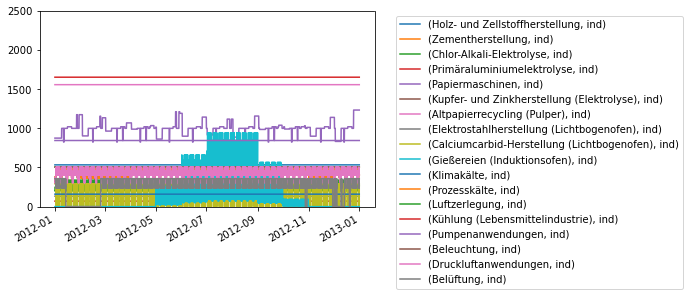

In [58]:
ind_ts_dict[("SQ", "50%")].iloc[:-1].plot()
plt.ylim([0,2500])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

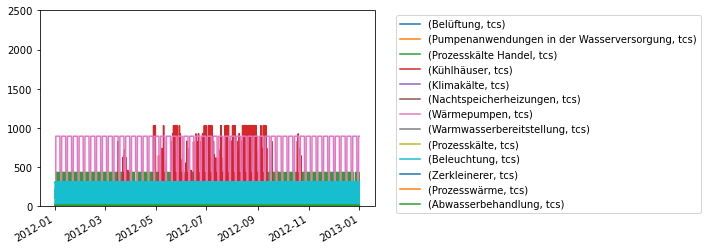

In [59]:
tcs_ts_dict[("SQ", "50%")].iloc[:-1].plot()
plt.ylim([0,2500])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

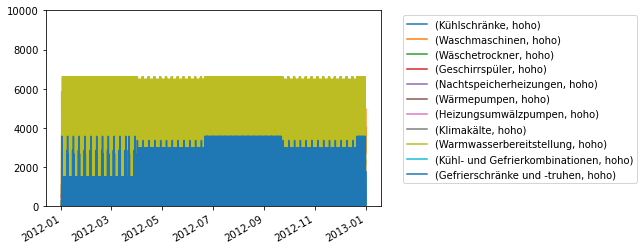

In [60]:
hoho_ts_dict[("SQ", "50%")].iloc[:-1].plot()
plt.ylim([0,10000])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

##  Create availability time series per cluster
* Calculate weighted averages within clusters.
* Save the results, i.e. availability time series per cluster, to a csv file.

In [61]:
sector_dict = {}

for year in years:

    sector_dict[year] = {"ind": (availability_ind_pos, availability_ind_neg, potential_ind_T_dict[year]),
                       "tcs": (availability_tcs_pos, availability_tcs_neg, potential_tcs_T_dict[year]),
                       "hoho": (availability_hoho_pos, availability_hoho_neg, potential_hoho_T_dict[year])}

**Interpretation of availability factors per cluster**:
* Maximum availability per cluster does not necessarily have to be 1.
* A value of 0.88 implies that at maximum 88% of the overall cluster capacity are available at the same time. &rarr; Similar interpretation than simultaneity factor.
* Nevertheless, a rescaling is done here for the sake of easier interpretation. &rarr; I.e. maximum values will be 1.0 and cluster capacity is adapted accordingly.

In [62]:
np.sort(potential_T_dict["SQ"].loc["cluster"].unique())

array([2.0, 12.0, 112.0, 2112.0, 2113.0], dtype=object)

In [63]:
# Extract info on combined clusters for tcs and hoho separately in order not to overwrite it
tcs_hoho_clusters = potential_dict["SQ"].loc[potential_dict["SQ"].index.get_level_values(1) == "tcs+hoho", 
                                             "cluster"].unique()

**_TODO: Check assignments here! Seems a bit buggy / inconvenient!_**

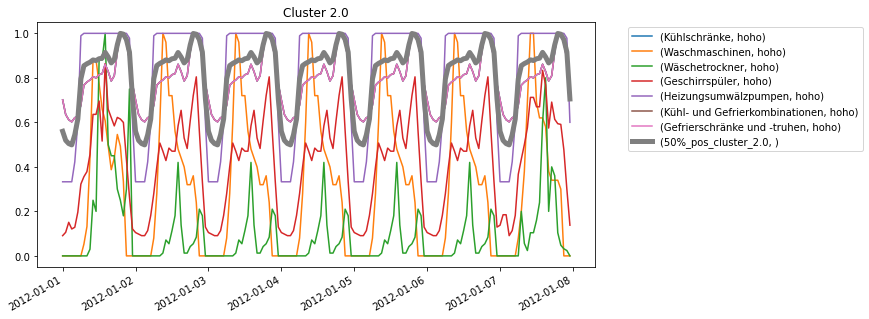

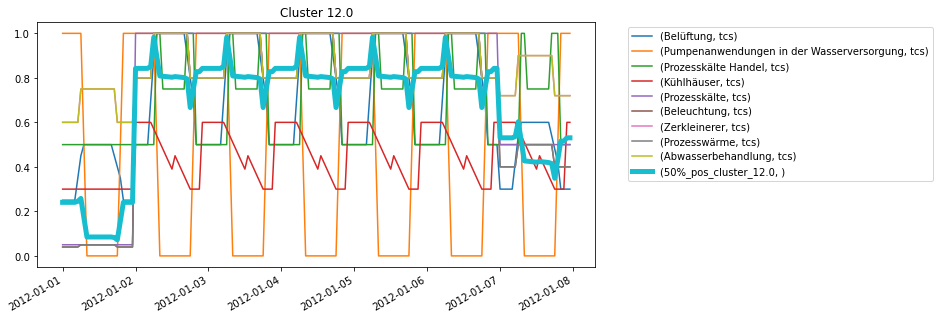

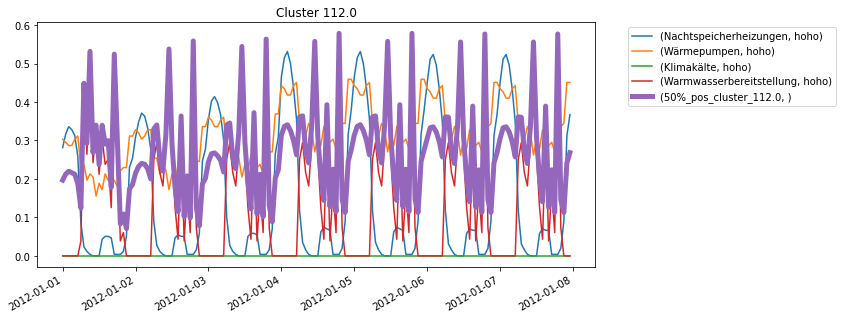

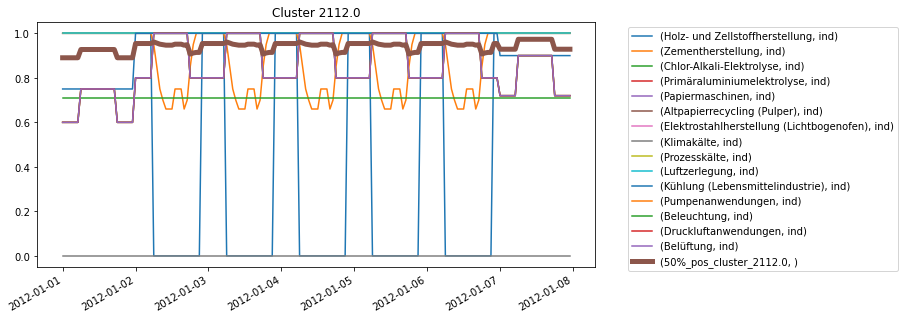

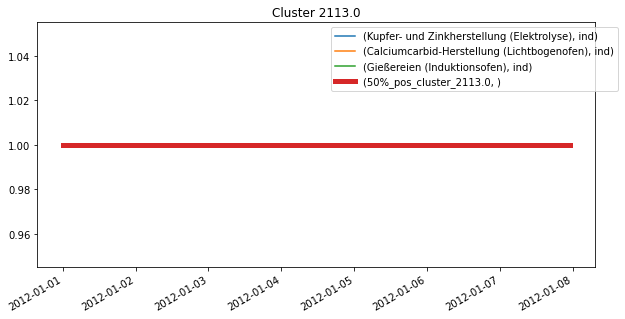

,25%_hoho_cluster-2_pos,25%_hoho_cluster-2_neg,50%_hoho_cluster-2_pos,50%_hoho_cluster-2_neg,75%_hoho_cluster-2_pos,75%_hoho_cluster-2_neg,25%_tcs_cluster-12_pos,25%_tcs_cluster-12_neg,50%_tcs_cluster-12_pos,50%_tcs_cluster-12_neg,...,50%_ind_cluster-2112_pos,50%_ind_cluster-2112_neg,75%_ind_cluster-2112_pos,75%_ind_cluster-2112_neg,25%_ind_cluster-2113_pos,25%_ind_cluster-2113_neg,50%_ind_cluster-2113_pos,50%_ind_cluster-2113_neg,75%_ind_cluster-2113_pos,75%_ind_cluster-2113_neg
2012-12-31 19:00:00,1.0000,0.0000,0.9993,0.3615,0.9855,0.4905,0.7761,0.2086,0.7483,0.2345,...,0.9385,0.6710,0.9408,0.6499,1.0,1.0,1.0,1.0,1.0,1.0
2012-12-31 20:00:00,0.9964,0.0118,0.9960,0.3386,0.9891,0.4717,0.8603,0.3065,0.8278,0.3270,...,0.9410,0.6619,0.9427,0.6419,1.0,1.0,1.0,1.0,1.0,1.0
2012-12-31 21:00:00,0.9677,0.1065,0.9720,0.2564,0.9464,0.2868,0.8603,0.3065,0.8278,0.3270,...,0.9410,0.6619,0.9427,0.6419,1.0,1.0,1.0,1.0,1.0,1.0
2012-12-31 22:00:00,0.9033,0.3018,0.9157,0.4522,0.8775,0.4416,0.8603,0.2982,0.8425,0.2965,...,0.9810,0.6389,0.9777,0.6162,1.0,1.0,1.0,1.0,1.0,1.0
2012-12-31 23:00:00,0.7310,0.5740,0.7051,0.5451,0.6541,0.4602,0.8603,0.2982,0.8425,0.2965,...,0.9810,0.6389,0.9777,0.6162,1.0,1.0,1.0,1.0,1.0,1.0


In [64]:
pot_cols = ["potential_pos_overall", "potential_neg_overall", "installed_cap"]
cols_of_interest = [i+"_"+j for i in cols for j in pot_cols]

# Use dicts and DataFrames to store overall cluster potential and availability time series per cluster
cluster_overall_pot_dict = {}
cluster_overall_ts_dict = {}
availability_clusters = pd.DataFrame(index=availability_ind_pos.index).drop("cluster")

# Create availability time series within clusters by calculating weighted averages
for year in years:
    
    cluster_overall_pot_df = pd.DataFrame(columns=cols_of_interest)
    load_timeseries = pd.DataFrame(index=overall_ts_dict[("SQ","50%")].iloc[:-1].index)
    
    for el in np.sort(potential_T_dict["SQ"].loc["cluster"].unique()):
        
        to_concat = []
        cluster_data = {}
        
        for col in cols:
            sector = potential_T_dict[year].loc[:,potential_T_dict[year].loc[
                "cluster"] == el].columns.get_level_values(1)[0]
            
            # introduce shortcuts for readability
            org_ava_pos = sector_dict[year][sector][0]
            org_ava_neg = sector_dict[year][sector][1]
            pots_T = sector_dict[year][sector][2]
            
            # Calculate a weighted average for positive potentials (weights: maximum potential information)
            ava_pos = org_ava_pos.loc[:,org_ava_pos.loc["cluster"] == el].drop("cluster")    
            pot_pos = pots_T.loc[col+"_potential_pos_overall", pots_T.loc["cluster"] == el]
            overall_pot_pos = pot_pos.sum()
            
            if overall_pot_pos != 0:
                ava_pos[col+"_pos_cluster_"+str(el)] = ava_pos.mul(pot_pos).div(overall_pot_pos).sum(axis=1)

                # Do rescaling: Adjust (reduce) potential information if necessary 
                # and scale max value of availability time series to 1            
                max_pot_pos = ava_pos[col+"_pos_cluster_"+str(el)].max() * overall_pot_pos
                ava_pos[col+"_pos_cluster_"+str(el)] = \
                    ava_pos[col+"_pos_cluster_"+str(el)].div(ava_pos[col+"_pos_cluster_"+str(el)].max())
            
            # Calculate a weighted average for negative potentials (weights: potential information)
            ava_neg = org_ava_neg.loc[:,org_ava_neg.loc["cluster"] == el].drop("cluster")    
            pot_neg = pots_T.loc[col+"_potential_neg_overall", pots_T.loc["cluster"] == el]
            overall_pot_neg = pot_neg.sum()
            
            if overall_pot_neg != 0:
                ava_neg[col+"_neg_cluster_"+str(el)] = ava_neg.mul(pot_neg).div(overall_pot_neg).sum(axis=1)

                # Do rescaling: Adjust (reduce) potential information if necessary 
                # and scale max value of availability time series to 1
                max_pot_neg = ava_neg[col+"_neg_cluster_"+str(el)].max() * overall_pot_neg
                ava_neg[col+"_neg_cluster_"+str(el)] = \
                    ava_neg[col+"_neg_cluster_"+str(el)].div(ava_neg[col+"_neg_cluster_"+str(el)].max())

            if el not in tcs_hoho_clusters:
                cluster_label = sector+"_cluster-"+str(int(el))
            else:
                cluster_label = "tcs+hoho_cluster-"+str(int(el))

            # show exemplarily availability time series for clusters
            if year == "SQ":
                availability_clusters[col+"_"+cluster_label+"_pos"] = ava_pos[col+"_pos_cluster_"+str(el)]
                availability_clusters[col+"_"+cluster_label+"_neg"] = ava_neg[col+"_neg_cluster_"+str(el)]
                availability_clusters = availability_clusters.round(4)
            
                if col == "50%":
                    # Show a sample week for the clusters (SQ, positive potentials and median only)
                    fig, ax = plt.subplots(figsize=(10,5))
                    _ = ava_pos.iloc[:168,:-1].plot(ax=ax)
                    _ = ava_pos.iloc[:168,-1:].plot(ax=ax, linewidth=5)
                    _ = plt.title("Cluster "+str(el))
                    _ = plt.legend(bbox_to_anchor=(1.05, 1))
                    plt.show()
                    fig.savefig("cluster_"+str(el)+".png")
                    plt.close()
            
            # Save potential outputs
            cluster_data[col+"_"+pot_cols[0]] = max_pot_pos
            cluster_data[col+"_"+pot_cols[1]] = max_pot_neg
            
            # Assign load profiles and store them in a dict
            load_timeseries[col+"_"+cluster_label] = overall_ts_dict[(year, col)].loc[
                :,overall_ts_dict[(year, col)].loc["cluster"] == el].sum(axis=1).drop("cluster")
            
            max_cap = load_timeseries[col+"_"+cluster_label].max()
            
            cluster_data[col+"_"+pot_cols[2]] = max_cap
            
        # Combine potential outputs and store them in dict of DataFrames
        cluster_overall_pot_df.loc[cluster_label, [i+"_"+j for i in cols 
                                                           for j in pot_cols]] = cluster_data

        cluster_overall_pot_dict[year] = cluster_overall_pot_df
    
        cluster_overall_ts_dict[year] = load_timeseries

display(availability_clusters.tail())

Introduce some fixes:
* Normalize load profiles again in order to be able to use them combined with maximum capacity demand
* Rename installed\_cap to max\_cap in order to prevent misinterpretation

In [65]:
# Normalize load profiles (for usage in oemof)
# Rename column to max cap in order to be able to distinct it from installed capacity
for year in years:
    cluster_overall_ts_dict[year] = cluster_overall_ts_dict[year].div(cluster_overall_ts_dict[year].max())
    for col in cols:
        cluster_overall_pot_dict[year].rename({col + "_installed_cap": col + "_max_cap" for col in cols},
                                      axis=1, inplace=True)

In [66]:
cluster_overall_pot_dict["SQ"].head()

,25%_potential_pos_overall,25%_potential_neg_overall,25%_max_cap,50%_potential_pos_overall,50%_potential_neg_overall,50%_max_cap,75%_potential_pos_overall,75%_potential_neg_overall,75%_max_cap
hoho_cluster-2,2588.54,500,8885.4,4981.6,1832.52,9018.57,7179.02,6738.7,12517.2
tcs_cluster-12,936.389,1790.91,1259.2,1650.08,2897.16,1480.63,2103.95,3426.66,1599.27
tcs+hoho_cluster-112,651.617,266.547,7934.55,3425.54,1439.82,8130.49,6459.05,6171.83,8209.18
ind_cluster-2112,3706.31,1212.07,7124.06,6249.19,2804.93,9387.58,8864.83,4923.2,10957.1
ind_cluster-2113,104.25,23.75,1368.86,171,38,1596.51,317.75,58.75,1880.64


In [67]:
cluster_overall_pot_dict["2050"].head()

,25%_potential_pos_overall,25%_potential_neg_overall,25%_max_cap,50%_potential_pos_overall,50%_potential_neg_overall,50%_max_cap,75%_potential_pos_overall,75%_potential_neg_overall,75%_max_cap
hoho_cluster-2,1682.89,500,8284.54,3310.61,1344.15,8362.24,4586.56,3616.08,8439.93
tcs_cluster-12,1160.7,1876.68,2580.48,1886.39,2957.83,2924.75,2550.62,3677.43,3269.03
tcs+hoho_cluster-112,1349.98,864.038,4435.4,9557.3,4773.43,4514.84,25572.1,15863.5,4614.77
ind_cluster-2112,4092.9,923.671,8988.84,6606.55,2246.1,9984.22,9078.85,3833.35,10943.2
ind_cluster-2113,92.47,20.24,1489.78,162.64,36.13,1771.28,347.39,57.58,2052.78


In [68]:
cluster_overall_ts_dict["2050"].max()

25%_hoho_cluster-2          1.0
50%_hoho_cluster-2          1.0
75%_hoho_cluster-2          1.0
25%_tcs_cluster-12          1.0
50%_tcs_cluster-12          1.0
75%_tcs_cluster-12          1.0
25%_tcs+hoho_cluster-112    1.0
50%_tcs+hoho_cluster-112    1.0
75%_tcs+hoho_cluster-112    1.0
25%_ind_cluster-2112        1.0
50%_ind_cluster-2112        1.0
75%_ind_cluster-2112        1.0
25%_ind_cluster-2113        1.0
50%_ind_cluster-2113        1.0
75%_ind_cluster-2113        1.0
dtype: float64

In [69]:
cluster_labels = cluster_overall_pot_dict["SQ"].index.values
cluster_ts_by_cols = {}
ava_pos_ts_by_cols = {}
ava_neg_ts_by_cols = {}

# Split timeseries into subsets
for col in cols:
    for year in years:
        ava_cols = [i+"_"+j for i in [col] for j in cluster_labels]
        ava_cols_pos = [i+"_"+j+"_pos" for i in [col] for j in cluster_labels]
        ava_cols_neg = [i+"_"+j+"_neg" for i in [col] for j in cluster_labels]

        cluster_ts_by_cols[col+"_"+year] = cluster_overall_ts_dict[year][ava_cols]
        ava_pos_ts_by_cols[col+"_"+year] = availability_clusters[ava_cols_pos]
        ava_neg_ts_by_cols[col+"_"+year] = availability_clusters[ava_cols_neg]

In [70]:
cluster_ts_by_cols["25%_SQ"]

,25%_hoho_cluster-2,25%_tcs_cluster-12,25%_tcs+hoho_cluster-112,25%_ind_cluster-2112,25%_ind_cluster-2113
2012-01-01 00:00:00,0.140289,0.185198,0.036134,0.892218,0.373451
2012-01-01 01:00:00,0.154073,0.185198,0.032919,0.892218,0.373451
2012-01-01 02:00:00,0.183522,0.185198,0.031771,0.892218,0.373451
2012-01-01 03:00:00,0.164152,0.185198,0.031311,0.892218,0.373451
2012-01-01 04:00:00,0.168729,0.185198,0.032230,0.892218,0.373451
...,...,...,...,...,...
2012-12-31 19:00:00,0.586753,0.268081,0.477109,0.968973,0.241954
2012-12-31 20:00:00,0.698687,0.263759,0.267413,0.971168,0.241954
2012-12-31 21:00:00,0.650251,0.263759,0.048649,0.971168,0.241954
2012-12-31 22:00:00,0.501616,0.263759,0.046777,0.971168,0.433939


In [71]:
if write_outputs:
    availability_clusters.to_csv(path_folder_availability+filename_availability_out, sep=";", decimal=",")
    write_multiple_sheets(cluster_ts_by_cols, path_folder_parameterization, 
                          filename_load_profiles_out+".xlsx")

## Group the data within the clusters and write outputs
Determine, how the grouping will take place and which aggregation rules to apply for a parameter:
* *grouping_cols*: Columns to group by (cluster numbers)
* *mean_cols*: Columns for which the weighted average is used
* *sum_cols*: Columns for which entries are summed up

The average positive potential is used for calculating weigthed averages.<br>
> _Note: Again, there are possible alternatives here:_
> * _Use the installed capacity &rarr; drawback: missing for most demand response categories._
> * _Use positive or negative capacity dependent on parameter. &rarr; drawback: may lead to inconsistencies due to differing weights._

In [72]:
# Extract parameters of interest for further model-based analyses
params_of_interest_all = params_tbu + params_remaining
params_of_interest_all.remove("year_key")
params_of_interest = set()
for el in params_of_interest_all:
    params_of_interest.add(el[4:])
params_of_interest = list(params_of_interest)

In [73]:
grouping_cols = ["cluster"]
other_cols = []

mean_list = []
sum_list = []
for k, v in parameters_groups_dict.items():
    if k not in params_of_interest:
        continue
    if v[0] == "mean":
        mean_list.append(k)
    elif v[0] == "sum":
        sum_list.append(k)
        
mean_cols = create_parameter_combinations(mean_list, cols)
sum_cols = create_parameter_combinations(sum_list, cols)

In [74]:
# Renaming of cluster identifiers
name_dict = {"ind_cluster-2112": "ind_cluster-1",
             "ind_cluster-2113": "ind_cluster-2",
             "tcs_cluster-12": "tcs_cluster",
             "hoho_cluster-2": "hoho_cluster",
             "tcs+hoho_cluster-112": "tcs_hoho_cluster"}

In [75]:
def round_of_rating(number):
    """Round a number to the closest quarter integer. """
    return round(number * 4) / 4

In [76]:
# Calculate the parameters for the clusters
ind_dict = {}
tcs_dict = {}
hoho_dict = {}
tcs_hoho_dict = {}
overall_dict = {}

pot_cols = ["potential_pos_overall", "potential_neg_overall", "max_cap"]
dur_cols = ["interference_duration_neg", "interference_duration_pos", 
            "regeneration_duration", "shifting_duration"]
cost_cols = ["fixed_costs", "variable_costs", "specific_investments"]
other_cols = ["maximum_activations_year", "installed_cap", "max_cap",
              "potential_neg_overall", "potential_pos_overall"]

for col in cols:
    for year in years:
        ind_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "ind"], 
                                                 grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                 sum_cols=sum_cols, other_cols=other_cols,
                                                 sector="ind", drop=[el for el in cols if el != col]).round(2)
        
        tcs_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "tcs"], 
                                                 grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                 sum_cols=sum_cols, other_cols=other_cols,
                                                 sector="tcs", drop=[el for el in cols if el != col]).round(2)
        
        hoho_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "hoho"], 
                                                  grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                  sum_cols=sum_cols,  other_cols=other_cols,
                                                  sector="hoho", drop=[el for el in cols if el != col]).round(2)
        
        tcs_hoho_dict[col+"_"+year] = group_potential(potential_dict[year][potential_dict[year].index.get_level_values(1) == "tcs+hoho"], 
                                                      grouping_cols, weight=col+"_potential_pos_overall", mean_cols=mean_cols, 
                                                      sum_cols=sum_cols,  other_cols=other_cols,
                                                      sector="tcs+hoho", drop=[el for el in cols if el != col]).round(2)
        
        cols_potentials = [i+"_"+j for i in [col] for j in pot_cols]

        # Update potential data with availability information from above
        if adjust_potentials:
            ind_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
            tcs_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
            hoho_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
            tcs_hoho_dict[col+"_"+year][cols_potentials] = \
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
        
        # Add country and bus information (needed in power market model)
        ind_dict[col+"_"+year][col+"_country"] = "DE"
        tcs_dict[col+"_"+year][col+"_country"] = "DE"
        hoho_dict[col+"_"+year][col+"_country"] = "DE"
        tcs_hoho_dict[col+"_"+year][col+"_country"] = "DE"
        
        ind_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        tcs_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        hoho_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        tcs_hoho_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        
        # Combine to dict holding all parameter data for the clusters
        overall_dict[col+"_"+year] = pd.concat([ind_dict[col+"_"+year], 
                                                tcs_dict[col+"_"+year], 
                                                hoho_dict[col+"_"+year], 
                                                tcs_hoho_dict[col+"_"+year]])
        
        # Adjust rounding: costs to 1 digit; durations to nearest quarter integer; other params to 0 digits
        cols_duration = [i+"_"+j for i in [col] for j in dur_cols]
        cols_costs = [i+"_"+j for i in [col] for j in cost_cols]
        cols_other = [i+"_"+j for i in [col] for j in other_cols]
        
        overall_dict[col+"_"+year][cols_duration] = overall_dict[col+"_"+year][cols_duration].apply(
            round_of_rating)
        overall_dict[col+"_"+year][cols_costs] = overall_dict[col+"_"+year][cols_costs].round(1)
        overall_dict[col+"_"+year][cols_other] = overall_dict[col+"_"+year][cols_other].round(0)
        
        # Do some renaming
        overall_dict[col+"_"+year].rename(name_dict, inplace=True)
        overall_dict[col+"_"+year].columns = overall_dict[col+"_"+year].columns.str[4:]

In [77]:
overall_dict["25%_2050"]

,fixed_costs,interference_duration_neg,interference_duration_pos,maximum_activations_year,regeneration_duration,shifting_duration,specific_investments,variable_costs,installed_cap,potential_neg_overall,potential_pos_overall,max_cap,country,from
cluster,,,,,,,,,,,,,,
ind_cluster-1,2.9,2.50,1.75,35.0,3.0,3.75,1.9,467.2,11554.0,924.0,4093.0,8989.0,DE,DE_bus_el
ind_cluster-2,24.9,3.50,1.75,1.0,3.0,5.00,10.4,1400.2,264.0,20.0,92.0,1490.0,DE,DE_bus_el
tcs_cluster,9.7,1.00,1.00,165.0,0.0,1.00,84.6,0.6,7310.0,1877.0,1161.0,2580.0,DE,DE_bus_el
hoho_cluster,340.4,0.25,0.25,2151.0,0.0,0.25,46.0,0.0,86427.0,500.0,1683.0,8285.0,DE,DE_bus_el
tcs_hoho_cluster,51.6,2.00,1.50,392.0,0.0,2.25,17.9,0.0,62310.0,864.0,1350.0,4435.0,DE,DE_bus_el


In [78]:
# Info on remaining categories is optionally stored in order to be able to match it with availability time series
# resp. to assign similar availability time series when data is missing.
if write_categories:
    potential_dict["SQ"].to_excel("remaining_categories.xlsx")

In [79]:
# Write the parameter outputs to Excel
if write_outputs:
    write_multiple_sheets(ind_dict, path_folder_parameterization, filename_out+"_ind.xlsx")
    write_multiple_sheets(tcs_dict, path_folder_parameterization, filename_out+"_tcs.xlsx")
    write_multiple_sheets(hoho_dict, path_folder_parameterization, filename_out+"_hoho.xlsx")
    write_multiple_sheets(tcs_hoho_dict, path_folder_parameterization, filename_out+"_tcs_hoho.xlsx") 
    write_multiple_sheets(overall_dict, path_folder_parameterization, filename_out+"_overall.xlsx") 

## Write outputs
Write outputs needed for the power market model runs separately to csv files

Do some adjustments:
* Simple column naming adjustment
* Timeseries adjustments / harmonization:
> __*NOTE*__: _2017 is used as a simulation year for the power market model._
> * _Availability time series were (mostly) derived for 2012._
> * _Since 2017 and 2012 both started with a Sunday, no shifts of weekdays is necessary._
> * _Only the last day of 2012 is cut here since 2012 was a leap year._
> * _At the end, this only is a very rough estimate / first guess which **should be improved**._

In [80]:
# Do some column naming adjustment
cases = ["25%_SQ", "50%_SQ", "75%_SQ"]

for case in cases:
    cluster_ts_by_cols[case].columns = cluster_ts_by_cols[case].columns.str[4:]
    ava_pos_ts_by_cols[case].columns = ava_pos_ts_by_cols[case].columns.str[4:-4]
    ava_neg_ts_by_cols[case].columns = ava_neg_ts_by_cols[case].columns.str[4:-4]

    cluster_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)
    ava_pos_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)
    ava_neg_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)

C:\Users\jkochems\anaconda3\envs\diss\lib\site-packages\pandas\core\frame.py:4290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [81]:
# Do time series harmonization thing
new_timeindex = pd.date_range(start="2017-01-01 00:00", periods=8784, freq="H")

for case in cases:
    cluster_ts_by_cols[case]["new_timeindex"] = new_timeindex
    ava_pos_ts_by_cols[case]["new_timeindex"] = new_timeindex
    ava_neg_ts_by_cols[case]["new_timeindex"] = new_timeindex
    
    cluster_ts_by_cols[case] = cluster_ts_by_cols[case].set_index("new_timeindex", drop=True).iloc[:8760].round(4)
    ava_pos_ts_by_cols[case] = ava_pos_ts_by_cols[case].set_index("new_timeindex", drop=True).iloc[:8760].round(4)
    ava_neg_ts_by_cols[case] = ava_neg_ts_by_cols[case].set_index("new_timeindex", drop=True).iloc[:8760].round(4)

<ipython-input-81-ce27ff7def71>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_ts_by_cols[case]["new_timeindex"] = new_timeindex
<ipython-input-81-ce27ff7def71>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ava_pos_ts_by_cols[case]["new_timeindex"] = new_timeindex
<ipython-input-81-ce27ff7def71>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [82]:
cluster_ts_by_cols["25%_SQ"]

,hoho_cluster,tcs_cluster,tcs_hoho_cluster,ind_cluster-1,ind_cluster-2
new_timeindex,,,,,
2017-01-01 00:00:00,0.1403,0.1852,0.0361,0.8922,0.3735
2017-01-01 01:00:00,0.1541,0.1852,0.0329,0.8922,0.3735
2017-01-01 02:00:00,0.1835,0.1852,0.0318,0.8922,0.3735
2017-01-01 03:00:00,0.1642,0.1852,0.0313,0.8922,0.3735
2017-01-01 04:00:00,0.1687,0.1852,0.0322,0.8922,0.3735
...,...,...,...,...,...
2017-12-31 19:00:00,0.5176,0.1604,0.6435,0.9256,0.3735
2017-12-31 20:00:00,0.4828,0.1852,0.3839,0.9256,0.3735
2017-12-31 21:00:00,0.4413,0.1852,0.0486,0.9256,0.3735


In [83]:
for case in cases:
    # Node information
    overall_dict[case].to_csv(path_folder_parameterization+"sinks_demand_response_el_"+case[:2]+".csv")
    # Load profile information
    cluster_ts_by_cols[case].to_csv(path_folder_parameterization+"sinks_demand_response_el_ts_"+case[:2]+".csv")
    # Availability information
    ava_pos_ts_by_cols[case].to_csv(
        path_folder_parameterization+"sinks_demand_response_el_ava_pos_ts_"+case[:2]+".csv")
    ava_neg_ts_by_cols[case].to_csv(
        path_folder_parameterization+"sinks_demand_response_el_ava_neg_ts_"+case[:2]+".csv")

# Bibliography
Gils, Hans Christian (2015): Balancing of Intermittent Renewable Power Generation by Demand Response and Thermal Energy Storage. Dissertation. Universität Stuttgart, Stuttgart.

Kochems, Johannes (2020): Lastflexibilisierungspotenziale in Deutschland - Bestandsaufnahme und Entwicklungsprojektionen. Langfassung. In: IEE TU Graz (Hg.): EnInnov 2020 - 16. Symposium Energieinnovation. Energy for Future - Wege zur Klimaneutralität. Graz, 12.-14.02, https://www.tugraz.at/fileadmin/user_upload/tugrazExternal/4778f047-2e50-4e9e-b72d-e5af373f95a4/files/lf/Session_E5/553_LF_Kochems.pdf, accessed 11.05.2020.